In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import csv
import json
import re
from io import StringIO
from scipy.signal import find_peaks

In [2]:
%matplotlib widget

# Cardiosomnography data preprocessing

The ECG data needs to be preprocessed, before the ECG data can be given as input for the neural network.

### Read the raw MoveSense ECG data

In [3]:
# Rij 2 participant 36 inladen
# Kenmerken van het bestand
ecg_file = r"C:/Users/esmee/OneDrive\Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_36/MovesenseECG-2024-08-06T23_21_24.442965_sharing.csv"

# Open het CSV-bestand en lees alle rijen in
with open(ecg_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Rij 2 (index 1) bevat de metadata als JSON
metadata_row = lines[1].strip()  # Verwijder spaties en newline

# Fix: JSON opschonen (verwijder vierkante haken in "id")
cleaned_metadata_row = re.sub(r'"id":"\[#(.*?)\]"', r'"id":"\1"', metadata_row)

# JSON omzetten naar een dictionary
try:
    metadata = json.loads(cleaned_metadata_row)
    print("Metadata uit rij 2:")
    for key, value in metadata.items():
        print(f"{key}: {value}")
except json.JSONDecodeError as e:
    print("Fout bij het parsen van de JSON:", e)

Metadata uit rij 2:
id: 60495
name: Record 1
createdAt: 2024-08-06T23:21:24.442965
modifiedAt: 2024-08-07T06:54:58.145
size: -1
durationSeconds: 27213
filename: MovesenseECG-2024-08-06T23:21:24.442965.csv
sensorId: Movesense 234130000642
sensorName: 234130000642
gender: 
yob: 


In [4]:
# Inladen participant 36
# Overige data inlezen (vanaf rij 3), zonder kolomnamen toe te voegen
data_string = "".join(lines[2:])  # Pak alles vanaf rij 3

# Lees de rest van het bestand als een dataframe zonder kolomnamen
df = pd.read_csv(StringIO(data_string), header=None, sep=";")
raw_ecg_samples = df[1].to_numpy()  
#hertz = 191
print("Amount of measured ECG values:", len(raw_ecg_samples))
print("\nFirst and last measured ECG values:\n", raw_ecg_samples)

df.columns = ["timestamp", "sample", "bpm"]
# Toon de eerste 10 rijen
print(df.head(10))

Amount of measured ECG values: 5185504

First and last measured ECG values:
 [-0.0359 -0.0309 -0.029  ... -0.0271 -0.0252 -0.024 ]
   timestamp  sample  bpm
0      0.013 -0.0359   91
1      0.018 -0.0309   91
2      0.023 -0.0290   91
3      0.028 -0.0294   91
4      0.033 -0.0336   91
5      0.038 -0.0412   91
6      0.043 -0.0492   91
7      0.048 -0.0507   91
8      0.053 -0.0450   91
9      0.058 -0.0412   91


### Visualize ECG values of raw data

In [5]:
plt.close()

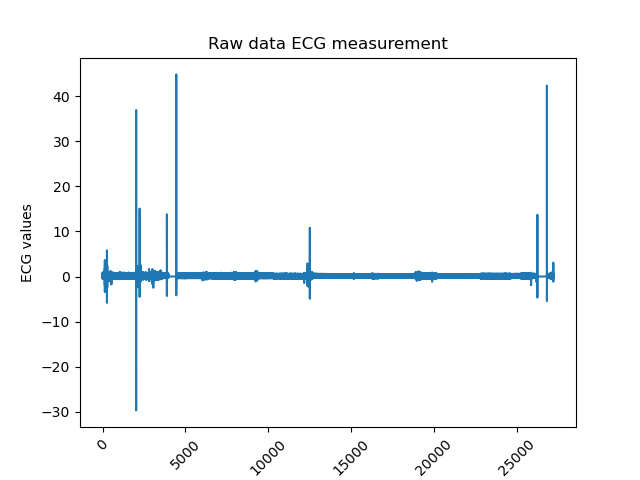

In [6]:
# participant 36
plt.close()
# Plot the ECG values of a whole night
plt.plot(df["timestamp"], df["sample"])
plt.title("Raw data ECG measurement")
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("ECG values")
plt.show()

<br><br>

---

### First, get all provided information about the measurement

In [7]:
try:
    # Get the participant number
    participant_number = ecg_file.split("/")[-2]
    participant_number = int(participant_number.split("_")[-1])
    print("Measurement of participant {0}".format(participant_number))
except:
    print("Participant number could not be extracted.")

Measurement of participant 36


In [8]:
print("Movesense ID:", metadata.get("id"))

Movesense ID: 60495


#### Get the date and time of the sleep session

#### Get start timestamp

In [9]:
try:
    # Get the start date out of the file name
    # Split de naam op 'T' om de datum en tijd te scheiden
    start_date_time = ecg_file.split("T")
    # Het deel voor de 'T' bevat de datum, we nemen het en splitsen de onderdelen
    start_date = start_date_time[0].split("-")[-3:]  # Haal jaar, maand en dag eruit
    start_date = "-".join(start_date)  # Zet de datum terug in het juiste formaat YYYY-MM-DD

    print("Measurement start date:", start_date)

    # Get the start time out of the file name
    start_time = start_date_time[1]
    start_time = start_time.split(".")[0]
    # Vervang underscores door dubbele punten om de tijd correct te formatteren
    start_time = start_time.replace("_", ":")
    print("Measurement start time:", start_time)  

    # Get the start date and time in a nice format
    start_timestamp = datetime.strptime("{0} {1}".format(start_date, start_time), "%Y-%m-%d %H:%M:%S")
    print(start_timestamp)
except:
    print("Start timestamp could not be extracted.\n")
    print("Are you sure you have the correct file name?")
    print("Expected file name should end like this: xxxxxxxxTxxxxxxZ_xxxxxxxxxxxx_ecg_stream.csv")
    print("Your file name looks like this:", ecg_file)





Measurement start date: 2024-08-06
Measurement start time: 23:21:24
2024-08-06 23:21:24


#### Get the measurement duration

In [10]:
# Get timestamps
first_timestamp = df["timestamp"].iloc[0]
last_timestamp = df["timestamp"].iloc[-1]
# Get duration in milliseconds
duration_milliseconds = (last_timestamp - first_timestamp)*1000 # tijd staat in seconde, om naar milliseconde te gaan *1000
print("Measurement took {0} milliseconds.".format(duration_milliseconds))

Measurement took 27213514.0 milliseconds.


In [11]:
# Get the measurement duration in seconds
duration_seconds = int(duration_milliseconds / 1000)
# Make a single division to produce both the quotient (minutes) and the remainder (seconds)
minutes, seconds = divmod(duration_seconds, 60)
hours, minutes = divmod(minutes, 60)

In [12]:
print("The measurement duration took {0} seconds.".format(duration_seconds))
print("That amount equals with {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

The measurement duration took 27213 seconds.
That amount equals with 7 hours, 33 minutes, and 33 seconds.


#### Get end timestamp

In [13]:
# Add measurement duration to start timestamp
duration_timestamp = timedelta(seconds=duration_seconds)
end_timestamp = start_timestamp + duration_timestamp
print("Measurement started on {0}".format(start_timestamp))
print("Measurement  ended  on {0}".format(end_timestamp))

Measurement started on 2024-08-06 23:21:24
Measurement  ended  on 2024-08-07 06:54:57


#### Get interval between measurements

In [14]:
# Get average time between each measurement
measurement_interval = duration_seconds / len(df)
hertz = round(1/measurement_interval)
print("Average time interval between each measurement is: ")
print(" - {0:.3f} seconds.".format(measurement_interval))
print(" - {0:.3f} milliseconds.".format(measurement_interval*1000))
print("\nSample rate: {0} Hertz.".format(hertz))

Average time interval between each measurement is: 
 - 0.005 seconds.
 - 5.248 milliseconds.

Sample rate: 191 Hertz.


### Add extra Timestamps for better visualization

In [15]:
# Add extra column with timestamps
def add_timestamps(df, start_timestamp, end_timestamp):
    # Start timestamp and end timestamp
    print("Starting timestamp: ", start_timestamp)
    print("Ending timestamp:", end_timestamp, "\n\n")
    
    # Calculate the total amount of minutes between start- and end time
    total_minutes = (end_timestamp - start_timestamp).total_seconds() / 60
    # Calculate the total amount of measurement per minute
    measurements_per_minute = len(df) / total_minutes
    
    # Create a list of timestamps
    df["Timestamp"] = [start_timestamp + timedelta(minutes=i/measurements_per_minute) for i in range(len(df))]
    return df

In [16]:
# Add timestamps for each measurement
df = add_timestamps(df, start_timestamp, end_timestamp)
df

Starting timestamp:  2024-08-06 23:21:24
Ending timestamp: 2024-08-07 06:54:57 




timestamp  sample  bpm                  Timestamp
0            0.013 -0.0359   91 2024-08-06 23:21:24.000000
1            0.018 -0.0309   91 2024-08-06 23:21:24.005248
2            0.023 -0.0290   91 2024-08-06 23:21:24.010496
3            0.028 -0.0294   91 2024-08-06 23:21:24.015744
4            0.033 -0.0336   91 2024-08-06 23:21:24.020992
...            ...     ...  ...                        ...
5185499  27213.507 -0.0267   74 2024-08-07 06:54:56.973761
5185500  27213.512 -0.0278   74 2024-08-07 06:54:56.979008
5185501  27213.517 -0.0271   74 2024-08-07 06:54:56.984256
5185502  27213.522 -0.0252   74 2024-08-07 06:54:56.989504
5185503  27213.527 -0.0240   74 2024-08-07 06:54:56.994752

[5185504 rows x 4 columns]

### Visualize raw data

In [17]:
# Visualize ecg data at any time
def plot_data(df, ecg_samples=np.array([]), title="Raw data ECG measurement", y_range=[0,0], x_range=[0,0]):
    plt.close()
    # Plot the ECG values of a whole night
    if ecg_samples.any():
        ecg_samples = pd.Series(ecg_samples)
        plt.plot(df["Timestamp"], ecg_samples)
    else:
        #print(df["Timestamp"])
        # print(df.columns)
        # print(df)
        plt.plot(df["Timestamp"], df["sample"])

    # Plot y range
    if y_range != [0,0]:
        plt.ylim(y_range[0], y_range[1])
    # Plot x range
    if x_range != [0,0]:
        plt.xlim(x_range[0], x_range[1])


    plt.title(title)
    plt.xlabel("Timestamps")
    plt.xticks(rotation=30)
    plt.ylabel("ECG values")
    plt.show()

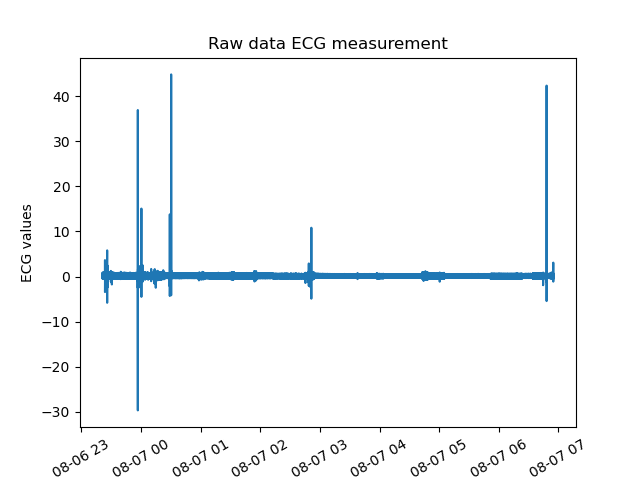

In [18]:
plot_data(df)

<br><br>

---

## Filter noise

### High pass filter

Filter High-pass at 0.5 Hertz to remove baseline wander.

In [19]:
# Signal processing functions for filtering the data
from scipy.signal import butter, filtfilt, iirnotch, resample

In [20]:
# High-pass filter to remove baseline wander
def highpass_filter(data, cutoff=0.5, fs=hertz, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [21]:
raw_ecg_samples

array([-0.0359, -0.0309, -0.029 , ..., -0.0271, -0.0252, -0.024 ])

In [22]:
# Apply highpass filter to raw ecg samples
highpass_filtered_ecg = highpass_filter(raw_ecg_samples)
highpass_filtered_ecg

array([ 0.00902975,  0.01391486,  0.01570028, ..., -0.00265076,
       -0.00144029, -0.00094451])

### Remove line noise

Line noise (50/60 Hertz) and any other constant-frequency noise should be removed with notch filters.

In [23]:
# Notch filter to remove power line noise (e.g., 50/60 Hz)
def notch_filter(data, freq=50, fs=hertz, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [24]:
print(hertz)

191


In [25]:
# Apply notch filter for both 50 Hz and (if needed) 60 Hz
filtered_ecg = notch_filter(highpass_filtered_ecg, freq=50, fs=hertz)  # Apply 50 Hz notch filter
filtered_ecg

array([ 0.00936908,  0.01357077,  0.01539489, ..., -0.00288734,
       -0.00188917, -0.00062886])

In [26]:
filtered_ecg = notch_filter(filtered_ecg, freq=60, fs=hertz)  # Apply 60 Hz notch filter (if applicable)
filtered_ecg

array([ 0.00930271,  0.01357314,  0.01545538, ..., -0.00264581,
       -0.0022035 , -0.00063417])

In [27]:
df["Timestamp"][0]

Timestamp('2024-08-06 23:21:24')

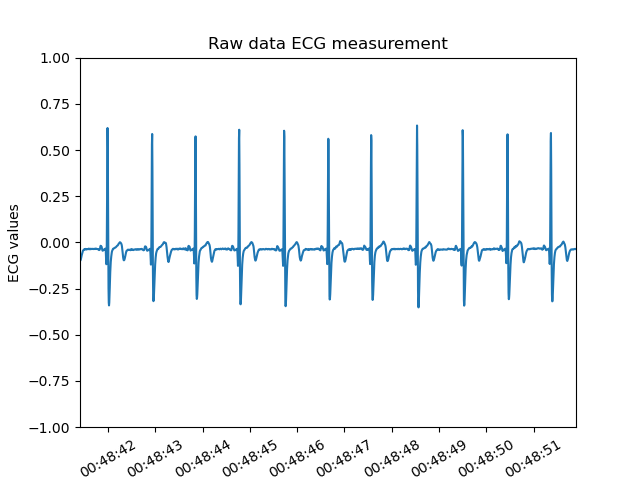

In [28]:
x_range = [df["Timestamp"][998000], df["Timestamp"][1000000]]
y_range = [-1, 1]
plot_data(df, y_range=y_range, x_range=x_range)

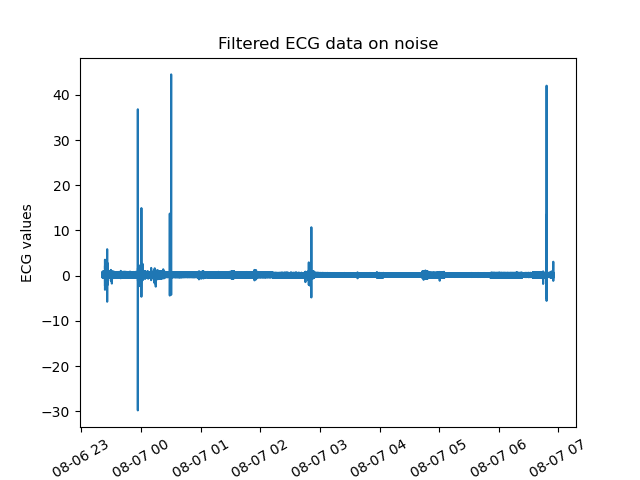

In [29]:
title = "Filtered ECG data on noise"
plot_data(df, filtered_ecg, title)

<br><br>

---

## Sample data at 256 Hertz

Sample the data from the originally measured 191 Hertz to the new 256 Hertz.

This resampling takes place, because the neural network is trained on ECG datasets of 256 Hertz.

#### Sample ECG data

In [30]:
new_hertz = 256 # New amount of Hertz
# Resample the ECG data from 191 Hz to 256 Hz
resampled_ecg = resample(filtered_ecg, int(len(filtered_ecg) * (new_hertz / hertz)))
resampled_ecg

array([ 0.00930271,  0.01323597,  0.01421998, ..., -0.00205139,
       -0.00241252,  0.00143071])

#### Resample time axis

In [31]:
original_timestamps = df["timestamp"].to_numpy() # Original timestamps numpy array
original_timestamps

array([1.3000000e-02, 1.8000000e-02, 2.3000000e-02, ..., 2.7213517e+04,
       2.7213522e+04, 2.7213527e+04])

In [32]:
# Lineaire interpolation for timestamps
time_original = np.arange(len(original_timestamps)) / hertz  # Original timesteps in seconds
time_resampled = np.linspace(0, time_original[-1], len(resampled_ecg))  # New timesteps in seconds

print("Original timesteps: ", time_original[:5], "...", time_original[-5:])
print("Resampled timesteps:", time_resampled[:5], "...", time_resampled[-5:])

Original timesteps:  [0.         0.0052356  0.0104712  0.01570681 0.02094241] ... [27149.20942408 27149.21465969 27149.21989529 27149.22513089
 27149.23036649]
Resampled timesteps: [0.         0.00390625 0.0078125  0.01171875 0.015625  ] ... [27149.21474149 27149.21864774 27149.22255399 27149.22646024
 27149.23036649]


In [33]:
# Interpolate original timestamps to new time-axis
resampled_timestamps = np.interp(time_resampled, time_original, original_timestamps)

print("Original timestamps: ", original_timestamps[:5], "...", original_timestamps[-5:])
print("Resampled timestamps:", resampled_timestamps[:5], "...", resampled_timestamps[-5:])

Original timestamps:  [0.013 0.018 0.023 0.028 0.033] ... [27213.507 27213.512 27213.517 27213.522 27213.527]
Resampled timestamps: [0.013      0.01673047 0.02046094 0.02419141 0.02792187] ... [27213.51207813 27213.51580859 27213.51953906 27213.52326953
 27213.527     ]


In [34]:
resampled_df = pd.DataFrame({
    'timestamp': resampled_timestamps,
    'sample': resampled_ecg
})

In [35]:
# Add timestamps for each measurement
resampled_df = add_timestamps(resampled_df, start_timestamp, end_timestamp)
resampled_df

Starting timestamp:  2024-08-06 23:21:24
Ending timestamp: 2024-08-07 06:54:57 




timestamp    sample                  Timestamp
0            0.013000  0.009303 2024-08-06 23:21:24.000000
1            0.016730  0.013236 2024-08-06 23:21:24.003915
2            0.020461  0.014220 2024-08-06 23:21:24.007831
3            0.024191  0.015961 2024-08-06 23:21:24.011746
4            0.027922  0.015564 2024-08-06 23:21:24.015662
...               ...       ...                        ...
6950199  27213.512078 -0.002551 2024-08-07 06:54:56.980423
6950200  27213.515809 -0.002628 2024-08-07 06:54:56.984338
6950201  27213.519539 -0.002051 2024-08-07 06:54:56.988254
6950202  27213.523270 -0.002413 2024-08-07 06:54:56.992169
6950203  27213.527000  0.001431 2024-08-07 06:54:56.996085

[6950204 rows x 3 columns]

In [36]:
df.shape

(5185504, 4)

In [37]:
print(resampled_df.head())

   timestamp    sample                  Timestamp
0   0.013000  0.009303 2024-08-06 23:21:24.000000
1   0.016730  0.013236 2024-08-06 23:21:24.003915
2   0.020461  0.014220 2024-08-06 23:21:24.007831
3   0.024191  0.015961 2024-08-06 23:21:24.011746
4   0.027922  0.015564 2024-08-06 23:21:24.015662


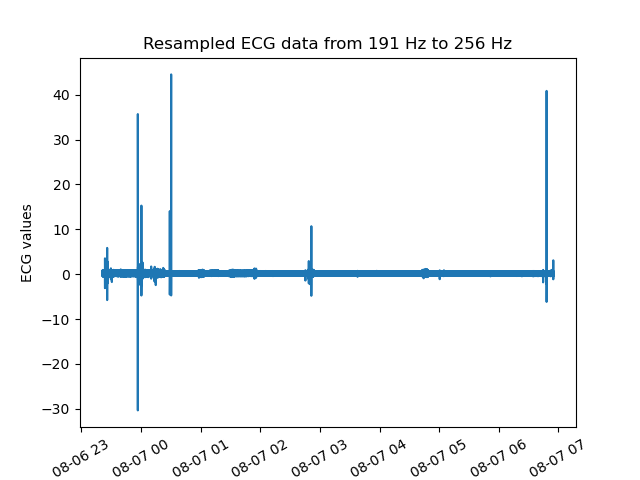

In [38]:
title = f"Resampled ECG data from {hertz} Hz to {new_hertz} Hz"
plot_data(resampled_df, title=title)

<br><br>

---

## Scale data - 1 / 2

### Subtract median data

The median of all data should be subtracted. The median of all ECG data should be equal to 0.

In [39]:
# Calculate the median of the resampled ECG data
median_ecg = np.median(resampled_ecg)
median_ecg

0.0016718561063655346

In [40]:
# Subtract the median to center the data around 0
centered_ecg = resampled_ecg - median_ecg

In [41]:
np.abs(np.median(centered_ecg))

1.0842021724855044e-19

In [42]:
resampled_df["sample"] = centered_ecg
resampled_df

timestamp    sample                  Timestamp
0            0.013000  0.007631 2024-08-06 23:21:24.000000
1            0.016730  0.011564 2024-08-06 23:21:24.003915
2            0.020461  0.012548 2024-08-06 23:21:24.007831
3            0.024191  0.014289 2024-08-06 23:21:24.011746
4            0.027922  0.013892 2024-08-06 23:21:24.015662
...               ...       ...                        ...
6950199  27213.512078 -0.004223 2024-08-07 06:54:56.980423
6950200  27213.515809 -0.004300 2024-08-07 06:54:56.984338
6950201  27213.519539 -0.003723 2024-08-07 06:54:56.988254
6950202  27213.523270 -0.004084 2024-08-07 06:54:56.992169
6950203  27213.527000 -0.000241 2024-08-07 06:54:56.996085

[6950204 rows x 3 columns]

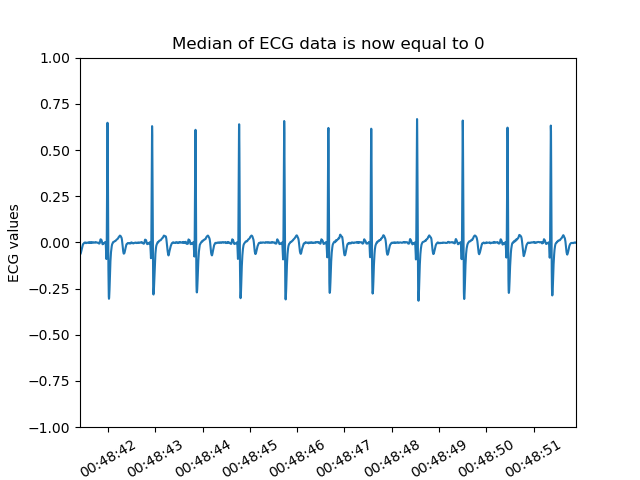

In [43]:
title = "Median of ECG data is now equal to 0"
plot_data(resampled_df, centered_ecg, title, y_range=y_range, x_range=x_range)

---

## Spikes & HeartRate

### Calculate threshold of heartbeat spikes

In [44]:
spike_threshold = np.std(resampled_df["sample"])
spike_threshold

0.1140685097565922

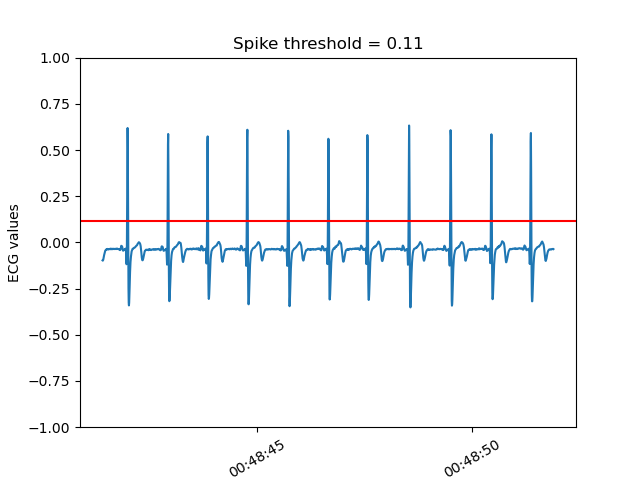

In [45]:
plt.close()
# Plot ECG values with threshold line
plt.plot(df["Timestamp"][998000:1000000], df["sample"][998000:1000000])
plt.ylim([-1, 1])
# Plot threshold line
plt.axhline(spike_threshold, color="r")
plt.title("Spike threshold = {:.2f}".format(spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=30)
plt.ylabel("ECG values")
plt.show()

### Detect all potential spikes

In [46]:
# Detect all potential spikes
fs=hertz
peaks = find_peaks(df["sample"], height=spike_threshold, distance=fs*0.6)
peaks

(array([     40,     207,     357, ..., 5185127, 5185259, 5185405],
       dtype=int64),
 {'peak_heights': array([0.7507, 0.7195, 0.6668, ..., 0.6794, 0.6008, 0.6145])})

c:\Users\esmee\anaconda3\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


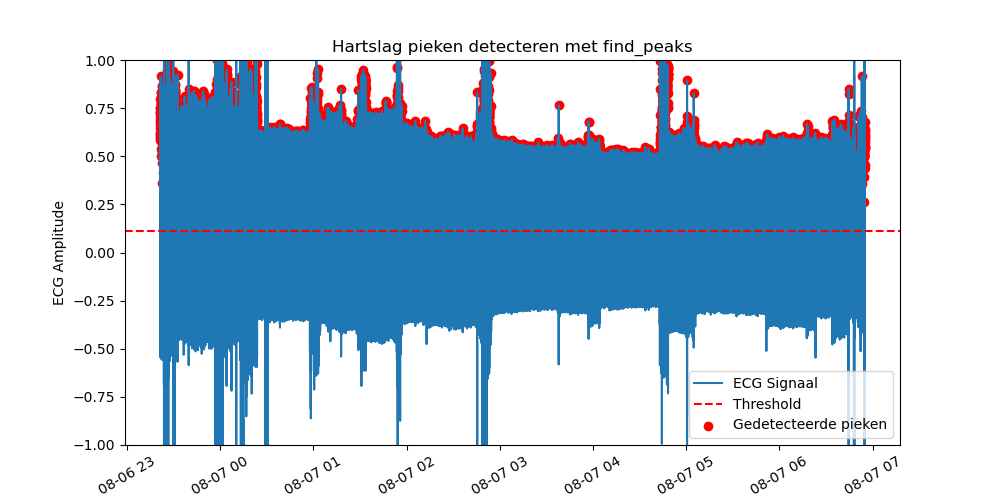

Aantal gedetecteerde pieken: 25824


In [47]:
# Gebruik find_peaks om pieken te detecteren
fs=hertz
peaks, properties = find_peaks(df["sample"], height=spike_threshold, distance=fs*0.6)

# Plot ECG met gedetecteerde pieken
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], df["sample"], label="ECG Signaal")
plt.ylim([-1, 1])
plt.axhline(spike_threshold, color="r", linestyle="--", label="Threshold")

# Plot pieken
plt.scatter(df["Timestamp"].iloc[peaks], df["sample"].iloc[peaks], color='red', marker='o', label="Gedetecteerde pieken")

# Labels en titel
plt.title("Hartslag pieken detecteren met find_peaks")
plt.xlabel("Tijd (s)")
plt.ylabel("ECG Amplitude")
plt.xticks(rotation=30)
plt.legend()
plt.show()

# Toon aantal pieken
print(f"Aantal gedetecteerde pieken: {len(peaks)}")

In [48]:
# Haal de tijdstempels van de gedetecteerde pieken
peak_timestamps = df["Timestamp"].iloc[peaks]

# Bereken de tijdsverschillen tussen de pieken (RR-intervals) in seconden
time_differences = peak_timestamps.diff().dt.total_seconds()

# Verwijder de eerste NaN waarde (er is geen verschil voor de eerste piek)
#time_differences = time_differences[1:]

# Bekijk de eerste paar tijdsverschillen
print(time_differences.head(20))

40           NaN
207     0.876399
357     0.787185
501     0.755697
639     0.724210
770     0.687475
895     0.655987
1019    0.650740
1141    0.640243
1268    0.666484
1403    0.708466
1545    0.745202
1687    0.745201
1816    0.676979
1942    0.661235
2068    0.661236
2198    0.682226
2341    0.750450
2502    0.844912
2656    0.808176
Name: Timestamp, dtype: float64


In [49]:
# Bereken de hartslag per piek (BPM)
bpm_values = 60 / time_differences

# Toon de BPM-waarden voor de eerste paar pieken
print(bpm_values.head(20))

40            NaN
207     68.461968
357     76.220965
501     79.396901
639     82.848897
770     87.275901
895     91.465227
1019    92.202723
1141    93.714418
1268    90.024667
1403    84.690020
1545    80.515082
1687    80.515190
1816    88.629042
1942    90.739298
2068    90.739161
2198    87.947396
2341    79.952029
2502    71.013313
2656    74.241254
Name: Timestamp, dtype: float64


In [50]:
# Maak een nieuw DataFrame voor de gedetecteerde pieken
spike_value_df = df.iloc[peaks]  # Gebruik de indices van de pieken om de relevante rijen te selecteren

# Voeg de tijdsverschillen toe aan dit nieuwe DataFrame (al eerder berekend)
spike_value_df["time_differences"] = time_differences.values
# Bereken de hartslag voor elke piek (in bpm)
spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"]

# Bekijk het nieuwe DataFrame
print(spike_value_df.head(20))

      timestamp  sample  bpm                  Timestamp  time_differences  \
40        0.213  0.7507   91 2024-08-06 23:21:24.209916               NaN   
207       1.048  0.7195   90 2024-08-06 23:21:25.086315          0.876399   
357       1.798  0.6668   90 2024-08-06 23:21:25.873500          0.787185   
501       2.518  0.6199   89 2024-08-06 23:21:26.629197          0.755697   
639       3.208  0.6130   87 2024-08-06 23:21:27.353407          0.724210   
770       3.863  0.5859   87 2024-08-06 23:21:28.040882          0.687475   
895       4.488  0.6493   88 2024-08-06 23:21:28.696869          0.655987   
1019      5.108  0.7488   89 2024-08-06 23:21:29.347609          0.650740   
1141      5.718  0.7980   90 2024-08-06 23:21:29.987852          0.640243   
1268      6.354  0.7317   92 2024-08-06 23:21:30.654336          0.666484   
1403      7.028  0.7294   93 2024-08-06 23:21:31.362802          0.708466   
1545      7.738  0.6977   93 2024-08-06 23:21:32.108004          0.745202   

C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\1584834455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["time_differences"] = time_differences.values
C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\1584834455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"]


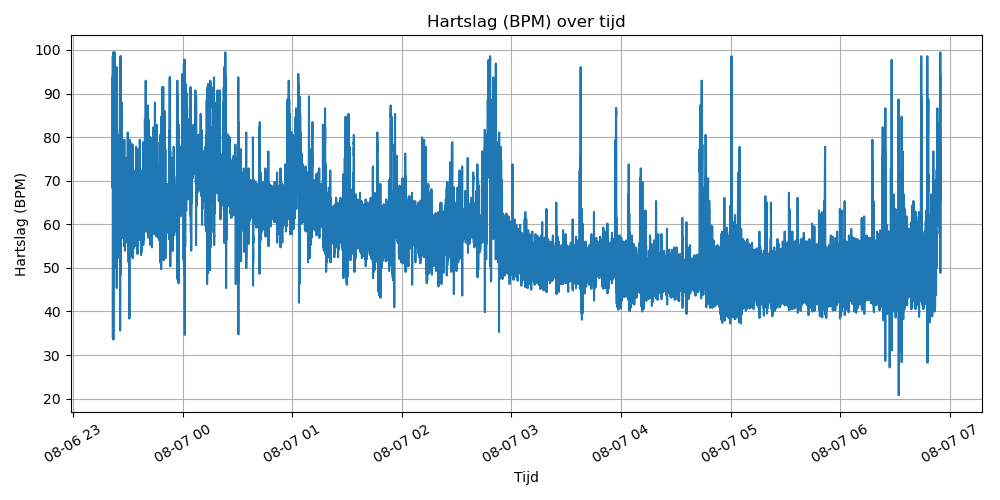

In [51]:
# Plot van de hartslag over tijd
plt.figure(figsize=(10, 5))
plt.plot(spike_value_df["Timestamp"], spike_value_df["heartrate"])
plt.title("Hartslag (BPM) over tijd")
plt.xlabel("Tijd")
plt.ylabel("Hartslag (BPM)")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
spike_value_df["heartrate"].max()

99.41873181465697

In [53]:
len(spike_value_df)

25824

In [ ]:
# # Detect all points above the threshold
# above_threshold = resampled_df.copy()
# above_threshold = above_threshold[above_threshold["sample"] > spike_threshold]
# above_threshold_samples = above_threshold.shape[0]
# print("Samples in cleaned dataset:", resampled_df.shape[0])
# print("Samples above threshold:   ", above_threshold_samples)
# above_threshold[:10]

Samples in cleaned dataset: 6950204
Samples above threshold:    187916


timestamp    sample                  Timestamp
50    0.199523  0.258901 2024-08-06 23:21:24.195771
51    0.203254  0.514816 2024-08-06 23:21:24.199687
52    0.206984  0.730017 2024-08-06 23:21:24.203602
53    0.210715  0.817591 2024-08-06 23:21:24.207518
54    0.214445  0.738116 2024-08-06 23:21:24.211433
55    0.218176  0.517269 2024-08-06 23:21:24.215348
56    0.221906  0.229679 2024-08-06 23:21:24.219264
274   1.035148  0.126752 2024-08-06 23:21:25.072826
275   1.038879  0.349238 2024-08-06 23:21:25.076742
276   1.042609  0.579895 2024-08-06 23:21:25.080657

In [ ]:
# # Variable how many seconds one spike lasts at max (200 milliseconds)
# spike_duration = 0.2
# # Calculate how many samples 1 spike lasts at max
# spike_duration_samples = int(spike_duration * hertz)
# print("1 spike is always happening in less than {0} samples.".format(spike_duration_samples))

1 spike is always happening in less than 38 samples.


### Detect only the real spikes

In [ ]:
# # Calculate time differences between sequenced measurements
# above_threshold["time_differences"] = above_threshold['Timestamp'].diff().dt.total_seconds() * 1000  # Difference in milliseconds
# above_threshold["time_differences"][:3]

50      NaN
51    3.916
52    3.915
Name: time_differences, dtype: float64

In [ ]:
# # Fill first value of time difference with 1000 instead of NaN, because there is no previous value (This detects the first spike)
# first_index = above_threshold.index[0]
# above_threshold.loc[first_index, "time_differences"] = 1000
# above_threshold[:5]

timestamp    sample                  Timestamp  time_differences
50   0.199523  0.258901 2024-08-06 23:21:24.195771          1000.000
51   0.203254  0.514816 2024-08-06 23:21:24.199687             3.916
52   0.206984  0.730017 2024-08-06 23:21:24.203602             3.915
53   0.210715  0.817591 2024-08-06 23:21:24.207518             3.916
54   0.214445  0.738116 2024-08-06 23:21:24.211433             3.915

In [ ]:
# # Group potential spikes in heartbeats
# minimum_spike_time_difference = 200
# above_threshold['heartbeat_group'] = (above_threshold['time_differences'] > minimum_spike_time_difference).cumsum()
# above_threshold[:20]

timestamp    sample                  Timestamp  time_differences  \
50    0.199523  0.258901 2024-08-06 23:21:24.195771          1000.000   
51    0.203254  0.514816 2024-08-06 23:21:24.199687             3.916   
52    0.206984  0.730017 2024-08-06 23:21:24.203602             3.915   
53    0.210715  0.817591 2024-08-06 23:21:24.207518             3.916   
54    0.214445  0.738116 2024-08-06 23:21:24.211433             3.915   
55    0.218176  0.517269 2024-08-06 23:21:24.215348             3.915   
56    0.221906  0.229679 2024-08-06 23:21:24.219264             3.916   
274   1.035148  0.126752 2024-08-06 23:21:25.072826           853.562   
275   1.038879  0.349238 2024-08-06 23:21:25.076742             3.916   
276   1.042609  0.579895 2024-08-06 23:21:25.080657             3.915   
277   1.046340  0.730046 2024-08-06 23:21:25.084573             3.916   
278   1.050070  0.732612 2024-08-06 23:21:25.088488             3.915   
279   1.053801  0.581857 2024-08-06 23:21:25.092403             3.915   
280   1.057531  0.331402 2024-08-06 23:21:25.096319             3.916   
475   1.784973  0.228180 2024-08-06 23:21:25.859827           763.508   
476   1.788703  0.454861 2024-08-06 23:21:25.863742             3.915   
477   1.792434  0.644536 2024-08-06 23:21:25.867658             3.916   
478   1.796164  0.719471 2024-08-06 23:21:25.871573             3.915   
479   1.799895  0.642290 2024-08-06 23:21:25.875488             3.915   
480   1.803625  0.439973 2024-08-06 23:21:25.879404             3.916   

     heartbeat_group  
50                 1  
51                 1  
52                 1  
53                 1  
54                 1  
55                 1  
56                 1  
274                2  
275                2  
276                2  
277                2  
278                2  
279                2  
280                2  
475                3  
476                3  
477                3  
478                3  
479                3  
480                3

In [ ]:
# # Select only the rows with the highest sample value in each group (The spike)
# # Add spike values to spike values dataset
# spike_value_df = above_threshold.loc[above_threshold.groupby('heartbeat_group')['sample'].idxmax()]
# # Keep al relevant columns
# spike_value_df = spike_value_df[["timestamp", "sample", "Timestamp"]]
# spike_value_df

timestamp    sample                  Timestamp
53           0.210715  0.817591 2024-08-06 23:21:24.207518
278          1.050070  0.732612 2024-08-06 23:21:25.088488
478          1.796164  0.719471 2024-08-06 23:21:25.871573
672          2.519875  0.665334 2024-08-06 23:21:26.631165
856          3.206281  0.642346 2024-08-06 23:21:27.351603
...               ...       ...                        ...
6949385  27210.475477  0.678513 2024-08-07 06:54:53.793267
6949537  27211.042508  0.680445 2024-08-07 06:54:54.388412
6949699  27211.646844  0.704343 2024-08-07 06:54:55.022711
6949875  27212.303406  0.667763 2024-08-07 06:54:55.711825
6950071  27213.034578  0.673252 2024-08-07 06:54:56.479249

[26097 rows x 3 columns]

### Plot spikes

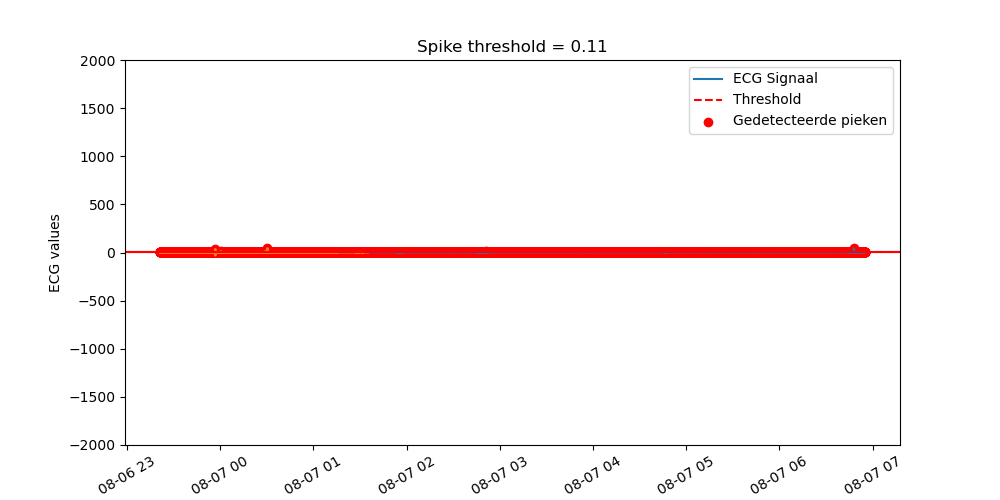

In [54]:
# inzoomen voor duidelijke weergave van ECG-signaal
resampled_x_range = [0, 2048000]
spikes_x_range = [0, 6864]

plt.close()
# Plot ECG values with threshold line
plt.plot(resampled_df["Timestamp"][resampled_x_range[0]:resampled_x_range[1]], resampled_df["sample"][resampled_x_range[0]:resampled_x_range[1]])
#plt.plot(df["Timestamp"][998000:1000000], df["sample"][998000:1000000])
plt.ylim([-2000, 2000])
# Plot threshold line
plt.axhline(spike_threshold, color="r")
# Plot all spikes
plt.scatter(spike_value_df["Timestamp"][spikes_x_range[0]:spikes_x_range[1]], spike_value_df["sample"][spikes_x_range[0]:spikes_x_range[1]], c="r", s=10)
# Customize lay-out
plt.title("Spike threshold = {:.2f}".format(spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=30)
plt.ylabel("ECG values")
plt.show()

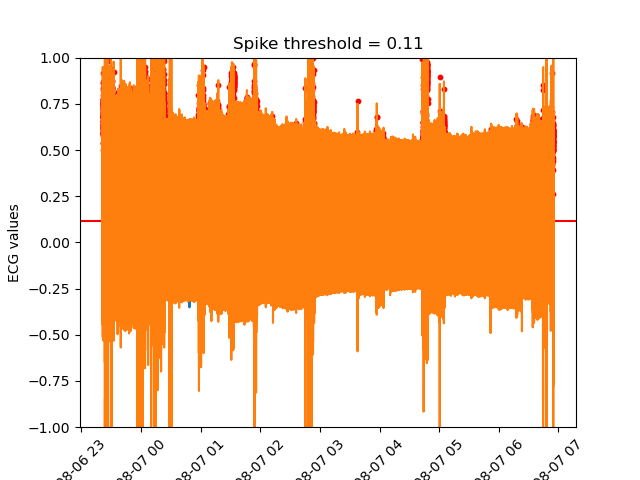

In [55]:
plt.close()
# Plot ECG values with threshold line
plt.plot(resampled_df["Timestamp"], resampled_df["sample"])
# Plot threshold line
# plt.axhline(spike_threshold, color="r")
# Plot all spikes
plt.scatter(spike_value_df["Timestamp"], spike_value_df["sample"], c="r", s=10)
# Customize lay-out
# plt.title("ECG measurement \nfrom {0} \n  till {1}\nSpike threshold = {2:.0f}".format(start_timestamp, end_timestamp, spike_threshold))
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("ECG values")
plt.show()

### Calculate InterBeat Interval

In [ ]:
# # Calculate time differences between all spikes (again, but only between real spikes now)
# spike_value_df["time_differences"] = spike_value_df['Timestamp'].diff().dt.total_seconds() * 1000  # Difference in milliseconds
# spike_value_df["time_differences"][:10]

53          NaN
278     880.970
478     783.085
672     759.592
856     720.438
1031    685.200
1200    661.707
1366    649.960
1529    638.214
1700    669.538
Name: time_differences, dtype: float64

In [ ]:
# # Fill first value of time difference with 1000 instead of NaN, because there is no previous value (This detects the first spike)
# first_index = spike_value_df.index[0]
# spike_value_df.loc[first_index, "time_differences"] = 1000
# spike_value_df[:5]

timestamp    sample                  Timestamp  time_differences
53    0.210715  0.817591 2024-08-06 23:21:24.207518          1000.000
278   1.050070  0.732612 2024-08-06 23:21:25.088488           880.970
478   1.796164  0.719471 2024-08-06 23:21:25.871573           783.085
672   2.519875  0.665334 2024-08-06 23:21:26.631165           759.592
856   3.206281  0.642346 2024-08-06 23:21:27.351603           720.438

### Calculate heart rate

In [ ]:
# spike_value_df["heartrate"] = 60 / spike_value_df["time_differences"] * 1000
# spike_value_df

timestamp    sample                  Timestamp  time_differences  \
53           0.210715  0.817591 2024-08-06 23:21:24.207518          1000.000   
278          1.050070  0.732612 2024-08-06 23:21:25.088488           880.970   
478          1.796164  0.719471 2024-08-06 23:21:25.871573           783.085   
672          2.519875  0.665334 2024-08-06 23:21:26.631165           759.592   
856          3.206281  0.642346 2024-08-06 23:21:27.351603           720.438   
...               ...       ...                        ...               ...   
6949385  27210.475477  0.678513 2024-08-07 06:54:53.793267           602.975   
6949537  27211.042508  0.680445 2024-08-07 06:54:54.388412           595.145   
6949699  27211.646844  0.704343 2024-08-07 06:54:55.022711           634.299   
6949875  27212.303406  0.667763 2024-08-07 06:54:55.711825           689.114   
6950071  27213.034578  0.673252 2024-08-07 06:54:56.479249           767.424   

          heartrate  
53        60.000000  
278       68.106746  
478       76.620035  
672       78.989773  
856       83.282670  
...             ...  
6949385   99.506613  
6949537  100.815768  
6949699   94.592613  
6949875   87.068323  
6950071   78.183638  

[26097 rows x 5 columns]

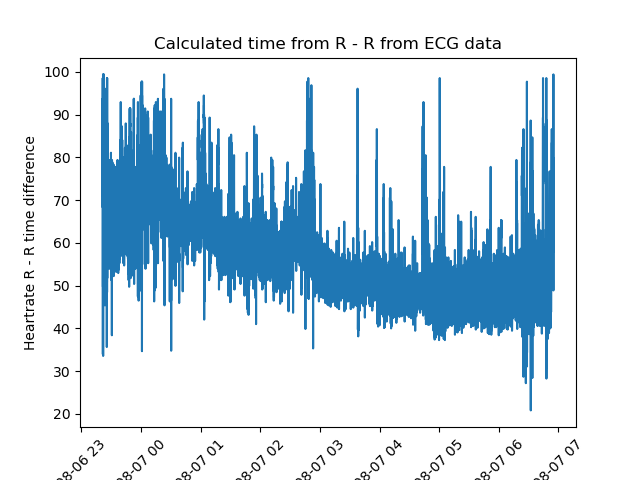

In [56]:
plt.close()
# Plot the ECG values of a whole night
plt.plot(spike_value_df["Timestamp"], spike_value_df["heartrate"])
plt.title("Calculated time from R - R from ECG data")
plt.xlabel("Timestamps")
plt.xticks(rotation=45)
plt.ylabel("Heartrate R - R time difference")
plt.show()

---

## Scale data - 2 / 2

### Scale ECG to range [-0.5, 0.5]

First measure the minimum and maximum values of every heartbeat. (So not of all ECG data, but just of the heartbeats).<br>
The data should be scaled, such that the 90th percentile (or greater) of the minimum and maximum heartbeat values lies within the range [-0.5, 0.5].

Movement artifacts and other noise may exceed the amplitude of most heartbeats. <br>
Noisy data values may lie within the range of [-1.0, -0.5] and [0.5, 1.0]. 

In [57]:
# Only get all heartbeat values (spikes)
spike_values = spike_value_df["sample"]
spike_values

40         0.7507
207        0.7195
357        0.6668
501        0.6199
639        0.6130
            ...  
5184778    0.5913
5184893    0.6310
5185127    0.6794
5185259    0.6008
5185405    0.6145
Name: sample, Length: 25824, dtype: float64

In [58]:
# Calculate the 90th percentile of min/max heartbeat values
min_value = np.percentile(spike_values, 10)
max_value = np.percentile(spike_values, 90)
print("The 90th percentile of the minimum heartbeat values:", min_value)
print("The 90th percentile of the maximum heartbeat values:", max_value)

The 90th percentile of the minimum heartbeat values: 0.4948
The 90th percentile of the maximum heartbeat values: 0.7416


In [59]:
# Scale factor based on the biggest, most absolut value
scale_factor = 0.5 / max(abs(min_value), abs(max_value))
print("Scale factor:", scale_factor)

Scale factor: 0.674217907227616


In [60]:
# Scale using the 90th percentile of min/max heartbeat values, without an adjustment
scaled_ecg = centered_ecg * scale_factor
resampled_df["sample"] = scaled_ecg
resampled_df

timestamp    sample                  Timestamp
0            0.013000  0.005145 2024-08-06 23:21:24.000000
1            0.016730  0.007797 2024-08-06 23:21:24.003915
2            0.020461  0.008460 2024-08-06 23:21:24.007831
3            0.024191  0.009634 2024-08-06 23:21:24.011746
4            0.027922  0.009367 2024-08-06 23:21:24.015662
...               ...       ...                        ...
6950199  27213.512078 -0.002847 2024-08-07 06:54:56.980423
6950200  27213.515809 -0.002899 2024-08-07 06:54:56.984338
6950201  27213.519539 -0.002510 2024-08-07 06:54:56.988254
6950202  27213.523270 -0.002754 2024-08-07 06:54:56.992169
6950203  27213.527000 -0.000163 2024-08-07 06:54:56.996085

[6950204 rows x 3 columns]

In [61]:
print("Is the median still equal to 0?")
print("Median:", np.abs(np.median(scaled_ecg)))

Is the median still equal to 0?
Median: 7.309888130950018e-20


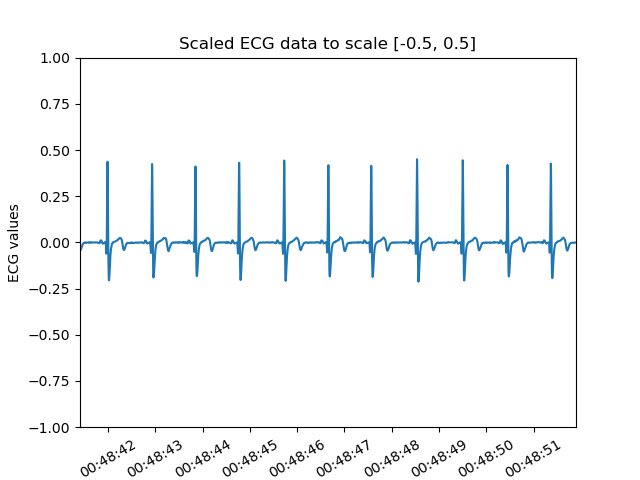

In [62]:
title = "Scaled ECG data to scale [-0.5, 0.5]"
plot_data(resampled_df, scaled_ecg, title, x_range=x_range, y_range=[-1, 1])

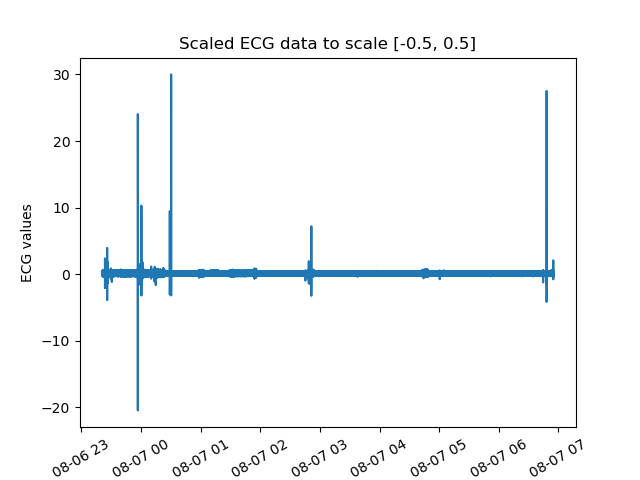

In [63]:
plot_data(resampled_df, scaled_ecg, title)

### Clamp outliers

All noisy datapoints and even the "tall" heartbeats should lie between the range of [-1.0, 1.0].<br>
Outliers should all be clamped to [-1.0, 1.0].

In [64]:
# Clamp values to [-1.0, 1.0] to handle noise and tall heartbeats
clamped_ecg = np.clip(scaled_ecg, -1.0, 1.0)
clamped_ecg

array([ 0.00514486,  0.00779673,  0.00846017, ..., -0.00251028,
       -0.00275376, -0.00016259])

In [65]:
print("Is the median still equal to 0?")
print("Median:", np.abs(np.median(clamped_ecg)))

Is the median still equal to 0?
Median: 7.309888130950018e-20


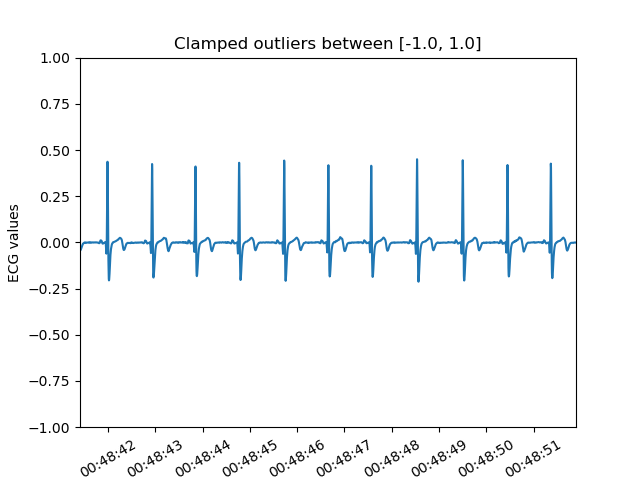

In [66]:
title = "Clamped outliers between [-1.0, 1.0]"
plot_data(resampled_df, clamped_ecg, title, x_range=x_range, y_range=[-1, 1])

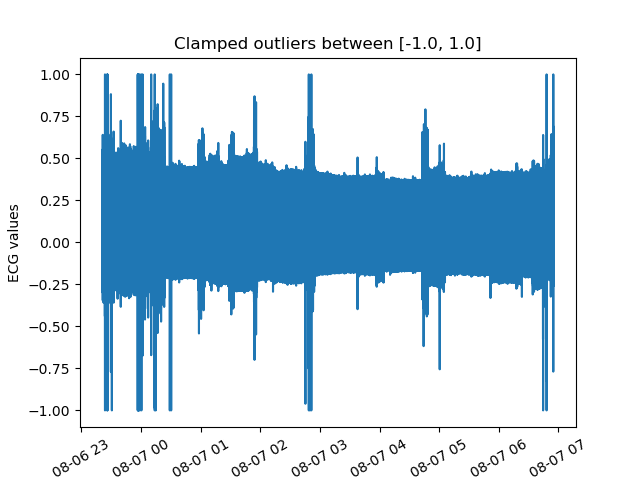

In [67]:
plot_data(resampled_df, clamped_ecg, title)

<br><br>

---

## Reshape into 30-second epochs

In the last preprocessing step, the ECG values should be divided into 30-second epochs. <br>
These 30-second epochs should be added to a new dataset as individual rows. <br>
The shape of the dataset will be [epoch_count * 7680]. The 7680 columns originate from 30 seconds * 256 Hertz. 

In [68]:
# Calculate the new 2D array shape
epoch_length = 30 * new_hertz # 30 seconds * 256 Hertz = 7680 datapoints per epoch
epoch_count = len(clamped_ecg) // epoch_length
print("Dataset shape: ({}, {})".format(epoch_count, epoch_length))

Dataset shape: (904, 7680)


In [69]:
# Trim ECG data down to the next nearest 30 second epoch length
trimmed_ecg = clamped_ecg[:epoch_count * epoch_length] # ECG length is now a multiple of 30 seconds
print("Amount of measurements taken into account:", len(trimmed_ecg))

Amount of measurements taken into account: 6942720


In [70]:
# Reshape the ECG data into 2D array
ecgs = clamped_ecg[:epoch_count * epoch_length].reshape((epoch_count, epoch_length))
pd.DataFrame(ecgs)

0         1         2         3         4         5         6     \
0    0.005145  0.007797  0.008460  0.009634  0.009367  0.007364  0.004047   
1   -0.218141 -0.186574 -0.156172 -0.129130 -0.106246 -0.084772 -0.064633   
2   -0.090738 -0.076264 -0.063257 -0.052605 -0.044498 -0.037152 -0.029389   
3   -0.006914 -0.003761 -0.000855 -0.000350 -0.002072 -0.004567 -0.005842   
4    0.021672  0.016121  0.009943  0.004485 -0.001194 -0.007735 -0.014876   
..        ...       ...       ...       ...       ...       ...       ...   
899  0.001204  0.000554  0.000361  0.000719  0.001164  0.001140  0.000885   
900 -0.006773 -0.005516 -0.004196 -0.003644 -0.002866 -0.001916 -0.001209   
901 -0.036845 -0.041636 -0.036599 -0.025406 -0.012821 -0.003854 -0.000795   
902  0.000663 -0.001669 -0.003627 -0.004437 -0.003483 -0.001831 -0.000961   
903 -0.001072 -0.000415  0.000853  0.001134  0.001782  0.001876  0.000949   

         7         8         9     ...      7670      7671      7672  \
0   -0.000714 -0.004523 -0.005597  ...  0.512559  0.469277  0.330953   
1   -0.048694 -0.037362 -0.029396  ... -0.073782 -0.169335 -0.210376   
2   -0.021662 -0.015729 -0.012681  ...  0.007885  0.005885  0.004954   
3   -0.006235 -0.006922 -0.007638  ...  0.031628  0.034059  0.037058   
4   -0.023271 -0.031956 -0.039760  ...  0.052392  0.048995  0.046047   
..        ...       ...       ...  ...       ...       ...       ...   
899  0.000601  0.000500  0.001017  ... -0.033835 -0.029474 -0.025429   
900 -0.000479 -0.000438 -0.000869  ...  0.001155 -0.007938 -0.014704   
901  0.000102  0.002536  0.007519  ...  0.006786  0.009209  0.009604   
902 -0.001290 -0.002154 -0.003359  ... -0.001145 -0.000543 -0.000236   
903  0.001087  0.000993  0.000521  ... -0.008836 -0.005702 -0.003945   

         7673      7674      7675      7676      7677      7678      7679  
0    0.142170 -0.042261 -0.181513 -0.259221 -0.283785 -0.275045 -0.249499  
1   -0.216750 -0.207116 -0.190774 -0.170372 -0.148143 -0.126816 -0.107490  
2    0.006996  0.010585  0.013407  0.012038  0.006087 -0.001027 -0.006208  
3    0.039901  0.041563  0.041296  0.038417  0.034506  0.030631  0.026308  
4    0.041668  0.034812  0.027162  0.021495  0.020618  0.023959  0.029319  
..        ...       ...       ...       ...       ...       ...       ...  
899 -0.021875 -0.018482 -0.014788 -0.011797 -0.009884 -0.008267 -0.007275  
900 -0.015731 -0.011266 -0.004047  0.001081 -0.001158 -0.011078 -0.024630  
901  0.009127  0.009169  0.009886  0.009990  0.008799  0.006558  0.003562  
902  0.000382  0.001006  0.001131  0.001062  0.000001 -0.000890 -0.000818  
903 -0.002848 -0.001764 -0.000339  0.001147  0.002637  0.004110  0.005056  

[904 rows x 7680 columns]

<br><br>

---

## Convert array to HDF5 file

Convert the 2D Numpy array with all the preprocessed ECG values of a single night of sleep to a HDF5 file format, which is required by the feed-forward neural network to predict a sleep score.

Structure of the HDF5 dataset file:
- `ecgs`:
  - 2D array of floats (size: epoch_count x 7680)
  - Where 7680 = 30 x 256Hz.
  - Network was trained on raw ECG data that had been filtered and scaled appropriately. See **Data preprocessing** above.
- `demographics`:
  - 2D array of floats (size: 2 x 1):
    - 1st: sex (0=female, 1=male)
    - 2nd: age (age_in_years/100)
- `midnight_offset`:
  - A float that represents the clock time offset to the nearest midnight of when the recording began:
    - 0 = midnight
    - -1 = 24hr before midnight and 1 = 24hr after midnight
    - For example, 9pm = -0.125 and 3am = 0.125.
- `stages` (only required for training):
  - 2D array of floats (size: epoch_count x 1):
    - Stage mapping: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.
      - It is not uncommon to find REM mapped to 5. However, the network was trained with data with both AASM and R&K scorings, so a unified "deep sleep" score was mapped to 3. And because it's inconvenient to have a gap, REM was remapped to 4.
    - All "unscored" epochs should be mapped to 0 (also see weight below).
- `weights` (only required for training):
  - 2D array of floats (size: epoch_count x 1):
    - 0 (no weight) to 1 (full weight)
    - All "unscored" epochs should be given a weight of 0.

In [71]:
# Check if 'ecgs' is in correct format
print("ECG size should be: \t(epoch_count x 7680)")
print(f"ECG size is: \t\t{ecgs.shape}")

print("\nECG type should be a: \t2D numpy array of floats")
print(f"ECG types are: \t\t{type(ecgs)} \n\t\t\t{type(ecgs[1][1])}")

ECG size should be: 	(epoch_count x 7680)
ECG size is: 		(904, 7680)

ECG type should be a: 	2D numpy array of floats
ECG types are: 		<class 'numpy.ndarray'> 
			<class 'numpy.float64'>


#### Demographics

In [72]:
# Calculate demographics
def get_demographics(gender, age):
    # Convert gender in binary number
    if gender.lower() == "Male" or "M" or "Man":
        sex = 1
    elif gender.lower() == "Female" or "F" or "Woman":
        sex = 0
    else:
        return "Gender is not entered correctly. Please insert Male or Female"
    
    # Convert age in Floating number
    age = age/100
    
    # Return calculated demographics
    return np.array([sex, age])

In [73]:
# Get demographics
gender = "Male"
age = 40
demographics = get_demographics(gender, age)

In [74]:
# Check if 'demographics' is in correct format
print("Demographics size should be: \t(2 x 1)")
print(f"Demographics size is: \t\t{demographics.shape}")

print("\nDemographics should be contain a 2D array of floats representing:")
print(" - Sex: Binary digit (0=female or 1=male)")
print(" - Age: Floating number (age/100)")

print("\nDemographics variable contains:")
print(" - Sex:", demographics[0])
print(" - Age:", demographics[1])

Demographics size should be: 	(2 x 1)
Demographics size is: 		(2,)

Demographics should be contain a 2D array of floats representing:
 - Sex: Binary digit (0=female or 1=male)
 - Age: Floating number (age/100)

Demographics variable contains:
 - Sex: 1.0
 - Age: 0.4


In [75]:
from tabulate import tabulate

In [76]:
table = [[gender, age]]
headers = ["Gender", "Age"]
print(tabulate(table, headers, tablefmt="pretty"))

+--------+-----+
| Gender | Age |
+--------+-----+
|  Male  | 40  |
+--------+-----+


#### Midnight offset

In [77]:
import datetime

In [78]:
# Calculate midnight offset
def get_midnight_offset(start_date_time):
    # Get start time from start date time
    start_time = start_date_time.strftime("%X")
    print(start_time)

    # Get sleep time
    hours = int(start_date_time.strftime("%H"))
    minutes = int(start_date_time.strftime("%M"))
    seconds = int(start_date_time.strftime("%S"))
    # Calculate clock time offset to nearest midnight of when recording began
    offset = ((seconds / 60 + minutes) / 60 + hours) / 24

    # Calculate negative offset, if sleep started before midnight
    if start_time > "12:00:00":
        offset = -1 + offset
        
    return np.array([offset])

In [79]:
datetime.datetime.now()

datetime.datetime(2025, 5, 8, 9, 4, 6, 446530)

In [80]:
# Get midnight offset
# start_date_time = datetime.datetime(2024, 11, 19, 12, 0, 1) # test
start_date_time = datetime.datetime.now()
midnight_offset = get_midnight_offset(start_timestamp)

23:21:24


In [81]:
# Check if 'midnight_offset' is in correct format
print("Midnight offset should contain a float between the range [-1, 1] representing the clocktime offset of when the recording began.")
print("Midnight offset value:", midnight_offset[0])

Midnight offset should contain a float between the range [-1, 1] representing the clocktime offset of when the recording began.
Midnight offset value: -0.026805555555555638


In [82]:
ecgs

array([[ 5.14485854e-03,  7.79673095e-03,  8.46017125e-03, ...,
        -2.83784961e-01, -2.75045037e-01, -2.49498688e-01],
       [-2.18141253e-01, -1.86573918e-01, -1.56172431e-01, ...,
        -1.48143495e-01, -1.26816265e-01, -1.07489768e-01],
       [-9.07379104e-02, -7.62636093e-02, -6.32573263e-02, ...,
         6.08698575e-03, -1.02704852e-03, -6.20844896e-03],
       ...,
       [-3.68446700e-02, -4.16363992e-02, -3.65992395e-02, ...,
         8.79924532e-03,  6.55769602e-03,  3.56188956e-03],
       [ 6.62834757e-04, -1.66900929e-03, -3.62729790e-03, ...,
         1.39060840e-06, -8.90401605e-04, -8.17554753e-04],
       [-1.07178364e-03, -4.14567980e-04,  8.53098516e-04, ...,
         2.63748374e-03,  4.10986370e-03,  5.05569837e-03]])

In [83]:
np.median(ecgs)

1.252472353270665e-07

In [84]:
np.mean(ecgs)

-0.0011597274213377793

In [85]:
ecgs.shape

(904, 7680)

In [184]:
# # Stel dat 'ecgs' een numpy array is van de ECG-gegevens
# plt.plot(ecgs)  # Plot de waarden van de 'ecgs' array

# # Voeg labels en een titel toe
# plt.title("ECG Data")
# plt.xlabel("Time (samples)")
# plt.ylabel("ECG Amplitude")

# # Toon de plot
# plt.show()

## Create HDF5 file

In [86]:
import h5py

In [87]:
# Create or overwrite HDF5 file
with h5py.File("preprocessed_ecg_data.h5", 'w') as hdf5_file:
    ecgs_data = hdf5_file.create_dataset("ecgs", data=ecgs)
    demographics_data = hdf5_file.create_dataset("demographics", data=demographics)
    midnight_offset_data = hdf5_file.create_dataset("midnight_offset", data=midnight_offset)

In [88]:
np.mean(ecgs)

-0.0011597274213377793

## Read HDF5 file

In [89]:
# Open HDF5 file
with h5py.File("preprocessed_ecg_data.h5", 'r') as hdf5_file:
    ecgs_data = hdf5_file["ecgs"]
    demographics_data = hdf5_file["demographics"]
    midnight_offset_data = hdf5_file["midnight_offset"]
    print(ecgs_data[()])
    print(demographics_data[()])
    print(midnight_offset_data[()])

    print(hdf5_file)

[[ 5.14485854e-03  7.79673095e-03  8.46017125e-03 ... -2.83784961e-01
  -2.75045037e-01 -2.49498688e-01]
 [-2.18141253e-01 -1.86573918e-01 -1.56172431e-01 ... -1.48143495e-01
  -1.26816265e-01 -1.07489768e-01]
 [-9.07379104e-02 -7.62636093e-02 -6.32573263e-02 ...  6.08698575e-03
  -1.02704852e-03 -6.20844896e-03]
 ...
 [-3.68446700e-02 -4.16363992e-02 -3.65992395e-02 ...  8.79924532e-03
   6.55769602e-03  3.56188956e-03]
 [ 6.62834757e-04 -1.66900929e-03 -3.62729790e-03 ...  1.39060840e-06
  -8.90401605e-04 -8.17554753e-04]
 [-1.07178364e-03 -4.14567980e-04  8.53098516e-04 ...  2.63748374e-03
   4.10986370e-03  5.05569837e-03]]
[1.  0.4]
[-0.02680556]
<HDF5 file "preprocessed_ecg_data.h5" (mode r)>


<br><br>

---

## Test model

Test primary model with demographics and primary model without demographics.

When loading data, the network's code will by default test, if any values are outside [-1, 1] and if the median ~= 0.<br>
Test whether the model can predict a sleep score on the ECG data and the data preprocessing has gone right.

In [ ]:
# Test model in Python environment terminal with this single code line
'''
 > cd Model_sleep_stage_prediction
 > python .\train.py .\preprocessed_ecg_data.h5
'''

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\esmee\AppData\Local\Temp\ipykernel_20992\1054278429.py:2: SyntaxWarning: invalid escape sequence '\p'
  '''


'\n > cd Model_sleep_stage_prediction\n > python .\train.py .\\preprocessed_ecg_data.h5\n'

<br><br>

---

## Results.h5

The model from the _train.py_ file calculates a sleepscore and save the results in the _results.h5_ file. <br>
Check all of the results of this file.

In [90]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    # Get all groups
    print(results.keys())

<KeysViewHDF5 ['confusions', 'predictions']>


---

#### Confusion matrix

No labels are inserted for the 30-second epochs, so the model will not know the actual label, it will only know the predicted label. Because of this, the confusion matrix only shows the first array of the wake state. Only use this array for the visualizations, unless someone has annotated every 30-second epoch by hand. 

The 5 sleep stages are: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.

In [91]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    # Get confusion matrix
    print(results["confusions"], "\n")
    confusions = results["confusions"][()]
    print(confusions)

<HDF5 dataset "confusions": shape (1, 5, 5), type "<f4"> 

[[[210.  47. 453.  98.  96.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]


In [92]:
# Get the number of every predicted label
predicted_label_amount = confusions[0][0]
predicted_label_amount

array([210.,  47., 453.,  98.,  96.], dtype=float32)

In [93]:
print("0=Wake:\t   ", int(predicted_label_amount[0]))
print("1=N1/S1:   ", int(predicted_label_amount[1]))
print("2=N2/S2:   ", int(predicted_label_amount[2]))
print("3=N3/S3/S4:", int(predicted_label_amount[3]))
print("4=REM:\t   ", int(predicted_label_amount[4]))

0=Wake:	    210
1=N1/S1:    47
2=N2/S2:    453
3=N3/S3/S4: 98
4=REM:	    96


---

#### Predictions

The predictions shows every sleep stage prediction for every 30-second epoch.

The 5 sleep stages are: 0=Wake, 1=N1/S1, 2=N2/S2, 3=N3/S3/S4, 4=REM.

In [94]:
# Open HDF5 file
with h5py.File("results.h5", 'r') as results:
    print(results["predictions"], "\n")
    predictions = results["predictions"][()][0]
    print(predictions)

<HDF5 dataset "predictions": shape (1, 904), type "<f4"> 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 2. 3. 3. 3. 3. 3. 3. 2. 3. 3. 2. 2. 3. 3. 3. 2. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 1.
 2. 2. 0. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 3. 3. 3. 3. 2.
 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 2. 2. 0. 0

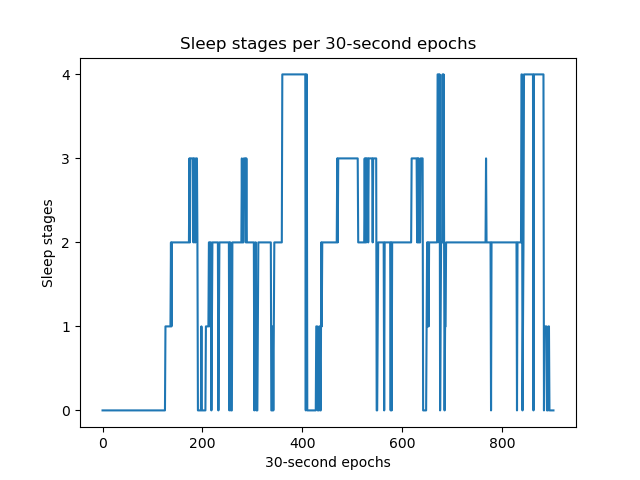

In [95]:
plt.close()
# Visialize sleep stages over time
plt.plot(predictions)
plt.title("Sleep stages per 30-second epochs")
plt.ylabel("Sleep stages")
plt.xlabel("30-second epochs")
plt.yticks(np.unique(predictions))
plt.show()

---

### Get other variables

Variable of how many times a person woke up at night.

In [96]:
# How many minutes are nessecary to see if someone is really awake
min_minutes_awake = 5

# Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
min_epochs_awake = min_minutes_awake * 2

In [97]:
wake_state = 0
wake_up_amount, wake_state_period = 0, 0
# Loop through all predictions
for idx, prediction in enumerate(predictions):
    # Check if person is in wake state
    if prediction == wake_state:
        wake_state_period += 1
    else:
        wake_state_period = 0

    # Check if person is in wake state for exactly 5 minutes
    if wake_state_period == min_epochs_awake:
        wake_up_amount += 1

In [98]:
# Check if wake_state is in begin of sleep
if np.mean(predictions[:min_epochs_awake]) == wake_state:
    wake_up_amount -= 1
# Check if wake_state is in end of sleep
if np.mean(predictions[-min_epochs_awake:]) == wake_state:
    wake_up_amount -= 1

print(f"Person woke up {wake_up_amount} times at the middle of the night.")

Person woke up 1 times at the middle of the night.


Short analysis of the first part of the night

In [99]:
awake_epochs, wake_state_period = 0, 0
# Loop through all predictions
for idx, prediction in enumerate(predictions):
    # Check if person is in wake state
    if prediction == wake_state:
        awake_epochs +=1
    else:
        break


sleep_on_set_latency = int(awake_epochs / 2)
print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

Person was awake for 63 minutes before falling asleep.


In [100]:
table = [[sleep_on_set_latency, wake_up_amount]]
headers = ["Minutes awake", "Times woken up"]
print(tabulate(table, headers, tablefmt="pretty"))

+---------------+----------------+
| Minutes awake | Times woken up |
+---------------+----------------+
|      63       |       1        |
+---------------+----------------+


In [101]:
def get_results(results_file):
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        # Get confusion matrix
        confusions = results["confusions"][()]
        print(confusions)
    # Get the number of every predicted label
    predicted_label_amount = confusions[0][0]
    predicted_label_amount
    print("0=Wake:\t   ", int(predicted_label_amount[0]))
    print("1=N1/S1:   ", int(predicted_label_amount[1]))
    print("2=N2/S2:   ", int(predicted_label_amount[2]))
    print("3=N3/S3/S4:", int(predicted_label_amount[3]))
    print("4=REM:\t   ", int(predicted_label_amount[4]))
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        predictions = results["predictions"][()][0]
    plt.close()
    # Visialize sleep stages over time
    plt.plot(predictions)
    plt.title("Sleep stages per 30-second epochs")
    plt.ylabel("Sleep stages")
    plt.xlabel("30-second epochs")
    plt.yticks(np.unique(predictions))
    plt.show()
    # How many minutes are nessecary to see if someone is really awake
    min_minutes_awake = 5

    # Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
    min_epochs_awake = min_minutes_awake * 2
    wake_state = 0
    wake_up_amount, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            wake_state_period += 1
        else:
            wake_state_period = 0

        # Check if person is in wake state for exactly 5 minutes
        if wake_state_period == min_epochs_awake:
            wake_up_amount += 1
    # Check if wake_state is in begin of sleep
    if np.mean(predictions[:min_epochs_awake]) == wake_state:
        wake_up_amount -= 1
    # Check if wake_state is in end of sleep
    if np.mean(predictions[-min_epochs_awake:]) == wake_state:
        wake_up_amount -= 1

    print(f"Person woke up {wake_up_amount} times at the middle of the night.")

    # Calculate epochs till person is asleep
    awake_epochs, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate sleep-on-set latency
    sleep_on_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

    # Calculate epochs from the moment person is awake
    awake_epochs = 0
    # Loop through all predictions backwards
    for idx, prediction in enumerate(np.flip(predictions)):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate wake-up-set latency
    wake_up_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {wake_up_set_latency} minutes before ending the measurement.")

    # Table with some results
    table = [[sleep_on_set_latency, wake_up_set_latency, wake_up_amount]]
    headers = ["Minutes awake before sleep", "Minutes awake before measurement end", "Times woken up"]
    print(tabulate(table, headers, tablefmt="pretty"))

    # Return all calculations for visualisation in table
    return predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount

[[[168.  78. 669. 105. 181.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    168
1=N1/S1:    78
2=N2/S2:    669
3=N3/S3/S4: 105
4=REM:	    181


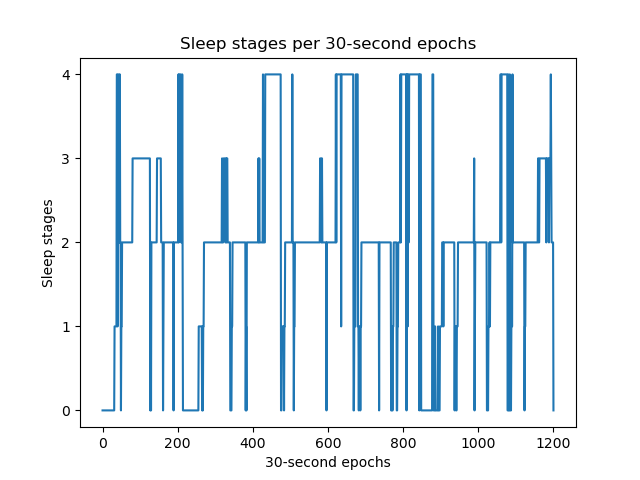

Person woke up 2 times at the middle of the night.
Person was awake for 16 minutes before falling asleep.
Person was awake for 0 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             16             |                  0                   |       2        |
+----------------------------+--------------------------------------+----------------+


(array([168.,  78., 669., 105., 181.], dtype=float32), 16, 0, 2)

In [ ]:
get_results("results_36_dag2.h5")

[[[1037.   14.   78.    4.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]]]
0=Wake:	    1037
1=N1/S1:    14
2=N2/S2:    78
3=N3/S3/S4: 4
4=REM:	    0


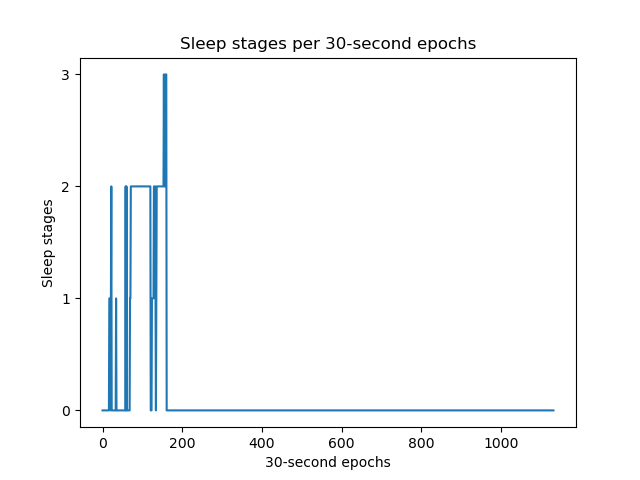

Person woke up 2 times at the middle of the night.
Person was awake for 8 minutes before falling asleep.
Person was awake for 486 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             8              |                 486                  |       2        |
+----------------------------+--------------------------------------+----------------+


(array([1037.,   14.,   78.,    4.,    0.], dtype=float32), 8, 486, 2)

In [ ]:
get_results("results_36_dag3.h5")

[[[160.  65. 498.  69. 143.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    160
1=N1/S1:    65
2=N2/S2:    498
3=N3/S3/S4: 69
4=REM:	    143


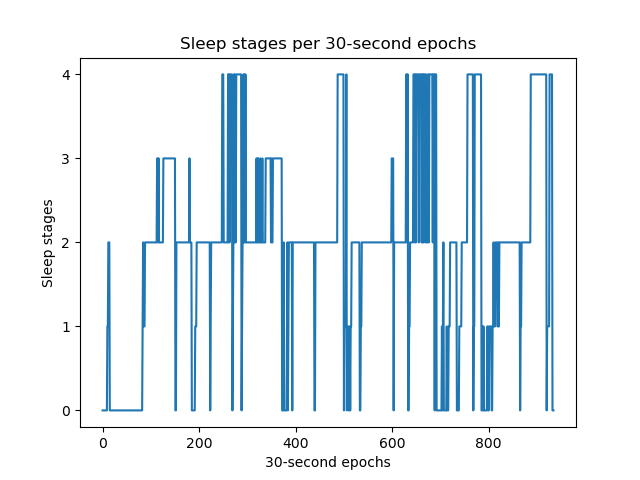

Person woke up 2 times at the middle of the night.
Person was awake for 5 minutes before falling asleep.
Person was awake for 1 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             5              |                  1                   |       2        |
+----------------------------+--------------------------------------+----------------+


(array([160.,  65., 498.,  69., 143.], dtype=float32), 5, 1, 2)

In [ ]:
get_results("results_36_dag4.h5")

[[[170.  46. 589.  79. 109.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    170
1=N1/S1:    46
2=N2/S2:    589
3=N3/S3/S4: 79
4=REM:	    109


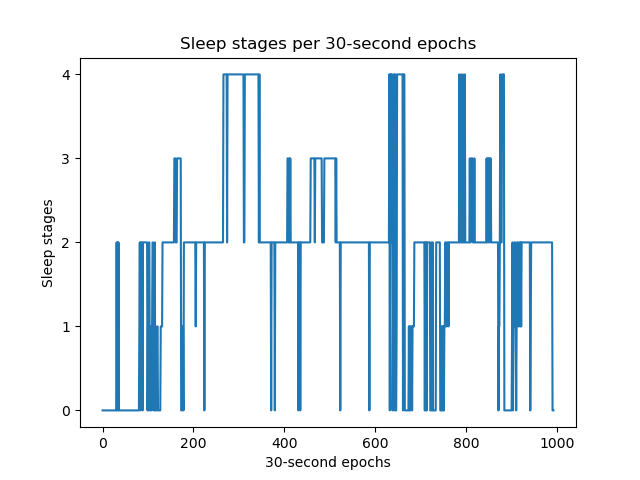

Person woke up 2 times at the middle of the night.
Person was awake for 15 minutes before falling asleep.
Person was awake for 1 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             15             |                  1                   |       2        |
+----------------------------+--------------------------------------+----------------+


(array([170.,  46., 589.,  79., 109.], dtype=float32), 15, 1, 2)

In [ ]:
get_results("results_36_dag5.h5")

[[[158.  73. 570.  81. 125.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    158
1=N1/S1:    73
2=N2/S2:    570
3=N3/S3/S4: 81
4=REM:	    125


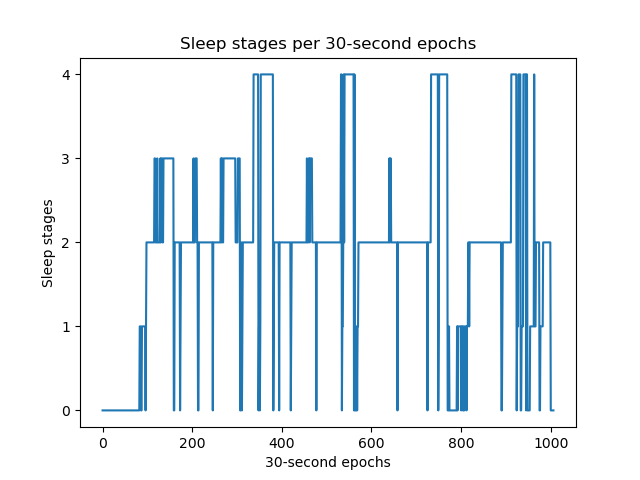

Person woke up 1 times at the middle of the night.
Person was awake for 41 minutes before falling asleep.
Person was awake for 3 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             41             |                  3                   |       1        |
+----------------------------+--------------------------------------+----------------+


(array([158.,  73., 570.,  81., 125.], dtype=float32), 41, 3, 1)

In [ ]:
get_results("results_36_dag6.h5")

[[[121.  60. 532.  65. 171.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    121
1=N1/S1:    60
2=N2/S2:    532
3=N3/S3/S4: 65
4=REM:	    171


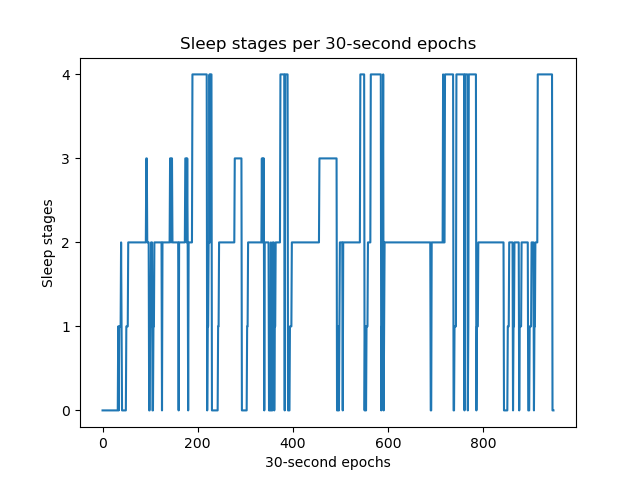

Person woke up 2 times at the middle of the night.
Person was awake for 16 minutes before falling asleep.
Person was awake for 1 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             16             |                  1                   |       2        |
+----------------------------+--------------------------------------+----------------+


(array([121.,  60., 532.,  65., 171.], dtype=float32), 16, 1, 2)

In [84]:
get_results("results_36_dag7.h5")

[[[179.  61. 490.  65. 113.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    179
1=N1/S1:    61
2=N2/S2:    490
3=N3/S3/S4: 65
4=REM:	    113


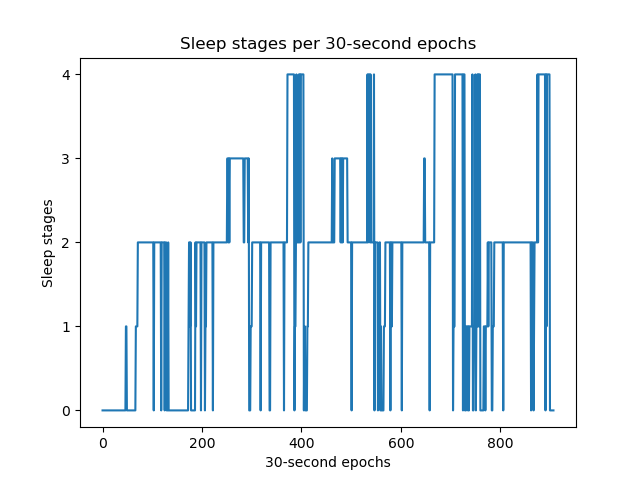

Person woke up 2 times at the middle of the night.
Person was awake for 23 minutes before falling asleep.
Person was awake for 4 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             23             |                  4                   |       2        |
+----------------------------+--------------------------------------+----------------+


(array([179.,  61., 490.,  65., 113.], dtype=float32), 23, 4, 2)

In [85]:
get_results("results_36_dag8.h5")

[[[ 63.  59. 667.  63. 148.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    63
1=N1/S1:    59
2=N2/S2:    667
3=N3/S3/S4: 63
4=REM:	    148


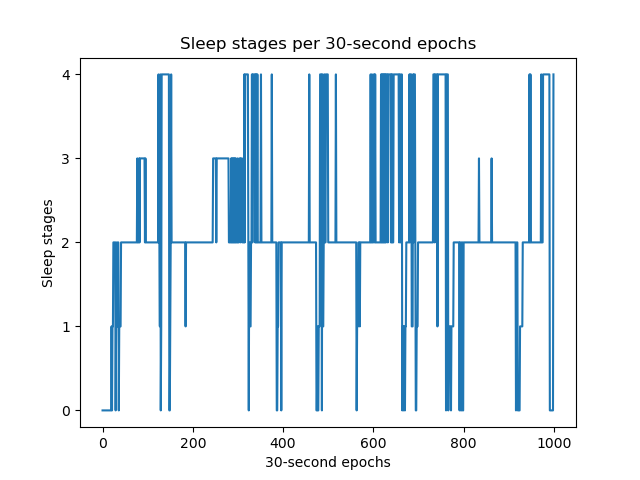

Person woke up 0 times at the middle of the night.
Person was awake for 10 minutes before falling asleep.
Person was awake for 0 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             10             |                  0                   |       0        |
+----------------------------+--------------------------------------+----------------+


(array([ 63.,  59., 667.,  63., 148.], dtype=float32), 10, 0, 0)

In [175]:
get_results("results_36_dag9.h5")

[[[103.   3.  82.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    103
1=N1/S1:    3
2=N2/S2:    82
3=N3/S3/S4: 0
4=REM:	    0


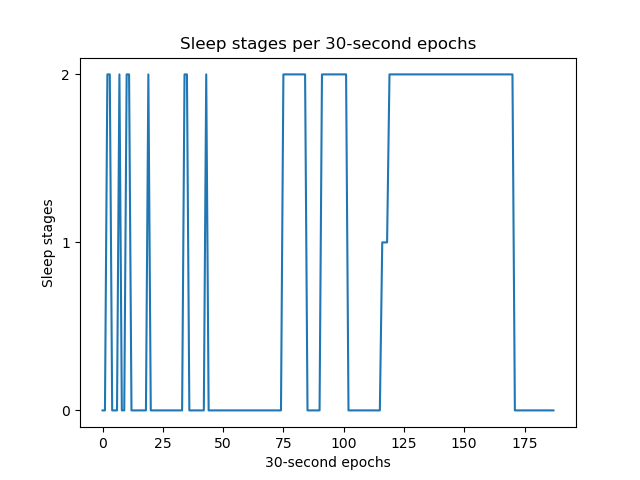

Person woke up 3 times at the middle of the night.
Person was awake for 1 minutes before falling asleep.
Person was awake for 8 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             1              |                  8                   |       3        |
+----------------------------+--------------------------------------+----------------+


In [267]:
predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount = get_results("results_36_dag10.h5")

---

# Sleep quality results

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import h5py
from tabulate import tabulate

In [103]:
# Get all information necessary for results table
def get_participant_info(ecg_file_name):
    try:
        # Get the participant number
        participant_number = ecg_file_name.split("/")[-2]
        participant_number = int(participant_number.split("_")[-1])
        print("Measurement of participant {0}".format(participant_number))
    except:
        print("Participant number could not be extracted.")  

    # Get the full file name
    file_name = ecg_file.split("/")[-1]

    try:
    # Get the start date out of the file name
        # Split de naam op 'T' om de datum en tijd te scheiden
        start_date_time = ecg_file.split("T")
        # Het deel voor de 'T' bevat de datum, we nemen het en splitsen de onderdelen
        start_date = start_date_time[0].split("-")[-3:]  # Haal jaar, maand en dag eruit
        start_date = "-".join(start_date)  # Zet de datum terug in het juiste formaat YYYY-MM-DD

        print("Measurement start date:", start_date)

        # Get the start time out of the file name
        start_time = start_date_time[1]
        start_time = start_time.split(".")[0]
        # Vervang underscores door dubbele punten om de tijd correct te formatteren
        start_time = start_time.replace("_", ":")
        print("Measurement start time:", start_time)  

        # Get the start date and time in a nice format
        start_timestamp = datetime.strptime("{0} {1}".format(start_date, start_time), "%Y-%m-%d %H:%M:%S")
        print(start_timestamp)
    except:
        print("Start timestamp could not be extracted.\n")
        print("Are you sure you have the correct file name?")
        print("Expected file name should end like this: xxxxxxxxTxxxxxxZ_xxxxxxxxxxxx_ecg_stream.csv")
        print("Your file name looks like this:", ecg_file)


    # Get df
    #df = pd.read_csv(ecg_file)
    # Get timestamps
    print(df["timestamp"].iloc[0])
    first_timestamp = df["timestamp"].iloc[0]
    last_timestamp = df["timestamp"].iloc[-1]
    # Get duration in milliseconds
    duration_milliseconds = (last_timestamp - first_timestamp) * 1000
    print("Measurement took {0} milliseconds.".format(duration_milliseconds))

    # Get the measurement duration in seconds
    duration_seconds = int(duration_milliseconds / 1000)
    # Make a single division to produce both the quotient (minutes) and the remainder (seconds)
    minutes, seconds = divmod(duration_seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print("The measurement duration took {0} seconds.".format(duration_seconds))
    print("That amount equals with {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

    # Add measurement duration to start timestamp
    duration_timestamp = timedelta(seconds=duration_seconds)
    end_timestamp = start_timestamp + duration_timestamp
    print("Measurement started on {0}".format(start_timestamp))
    print("Measurement  ended  on {0}".format(end_timestamp))

    # Return all information for results table
    return participant_number, start_timestamp, end_timestamp

In [104]:
get_participant_info(ecg_file)

Measurement of participant 36
Measurement start date: 2024-08-06
Measurement start time: 23:21:24
2024-08-06 23:21:24
0.013
Measurement took 27213514.0 milliseconds.
The measurement duration took 27213 seconds.
That amount equals with 7 hours, 33 minutes, and 33 seconds.
Measurement started on 2024-08-06 23:21:24
Measurement  ended  on 2024-08-07 06:54:57


(36,
 datetime.datetime(2024, 8, 6, 23, 21, 24),
 datetime.datetime(2024, 8, 7, 6, 54, 57))

In [105]:
# Get all results necessary for results table
def get_results(results_file):
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        # Get confusion matrix
        confusions = results["confusions"][()]
        print(confusions)
    # Get the number of every predicted label
    predicted_label_amount = confusions[0][0]
    predicted_label_amount
    print("0=Wake:\t   ", int(predicted_label_amount[0]))
    print("1=N1/S1:   ", int(predicted_label_amount[1]))
    print("2=N2/S2:   ", int(predicted_label_amount[2]))
    print("3=N3/S3/S4:", int(predicted_label_amount[3]))
    print("4=REM:\t   ", int(predicted_label_amount[4]))
    # Open HDF5 file
    with h5py.File(results_file, 'r') as results:
        predictions = results["predictions"][()][0]
    plt.close()
    # Visialize sleep stages over time
    plt.plot(predictions)
    plt.title("Sleep stages per 30-second epochs")
    plt.ylabel("Sleep stages")
    plt.xlabel("30-second epochs")
    plt.yticks(np.unique(predictions))
    plt.show()
    # How many minutes are nessecary to see if someone is really awake
    min_minutes_awake = 5

    # Calculates how many epochs define if someone is awake (*2, because 30-second epochs)
    min_epochs_awake = min_minutes_awake * 2
    wake_state = 0
    wake_up_amount, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            wake_state_period += 1
        else:
            wake_state_period = 0

        # Check if person is in wake state for exactly 5 minutes
        if wake_state_period == min_epochs_awake:
            wake_up_amount += 1
    # Check if wake_state is in begin of sleep
    if np.mean(predictions[:min_epochs_awake]) == wake_state:
        wake_up_amount -= 1
    # Check if wake_state is in end of sleep
    if np.mean(predictions[-min_epochs_awake:]) == wake_state:
        wake_up_amount -= 1

    print(f"Person woke up {wake_up_amount} times at the middle of the night.")

    # Calculate epochs till person is asleep
    awake_epochs, wake_state_period = 0, 0
    # Loop through all predictions
    for idx, prediction in enumerate(predictions):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate sleep-on-set latency
    sleep_on_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {sleep_on_set_latency} minutes before falling asleep.")

    # Calculate epochs from the moment person is awake
    awake_epochs = 0
    # Loop through all predictions backwards
    for idx, prediction in enumerate(np.flip(predictions)):
        # Check if person is in wake state
        if prediction == wake_state:
            awake_epochs +=1
        else:
            break

    # Calculate wake-up-set latency
    wake_up_set_latency = int(awake_epochs / 2)
    print(f"Person was awake for {wake_up_set_latency} minutes before ending the measurement.")

    # Table with some results
    table = [[sleep_on_set_latency, wake_up_set_latency, wake_up_amount]]
    headers = ["Minutes awake before sleep", "Minutes awake before measurement end", "Times woken up"]
    print(tabulate(table, headers, tablefmt="pretty"))

    # Return all calculations for visualisation in table
    return predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount

In [106]:
# Get all results in a table
def get_results_table(ecg_file_name, results_file_name):
    # Get participant info
    participant_number, start_timestamp, end_timestamp = get_participant_info(ecg_file_name)    

    # Get all calculations
    predicted_label_amount, sleep_on_set_latency, wake_up_set_latency, wake_up_amount = get_results(results_file_name)

    print("Deelnemer nummer:", participant_number)

    # Time person fell asleep and woke up
    asleep_timestamp = start_timestamp + timedelta(minutes=sleep_on_set_latency)
    awake_timestamp = end_timestamp - timedelta(minutes=wake_up_set_latency)

    headers = ["Datum van meting", str(start_timestamp.date())]
    table = [["Tijd meting begonnen", start_timestamp.time()],
             ["Tijd in slaap gevallen", asleep_timestamp.time()],
             ["Tijd wakker geworden", awake_timestamp.time()],
             ["Tijd meting beëindigt", end_timestamp.time()], 
             [],
             ["Minuten wakker voordat deelnemer in slaap viel", sleep_on_set_latency],
             ["Minuten wakker voordat deelnemer meting beëindigde", wake_up_set_latency],
             [],
             ["Aantal keer wakker geworden per nacht", wake_up_amount],
             [],
             ["Totaal aantal minuten gemeten", int(sum(predicted_label_amount))/2],
             ["Totaal aantal minuten in wakker fase", int(predicted_label_amount[0])/2],
             ["Totaal aantal minuten in N1 fase", int(predicted_label_amount[1])/2],
             ["Totaal aantal minuten in N2 fase", int(predicted_label_amount[2])/2],
             ["Totaal aantal minuten in N3 fase", int(predicted_label_amount[3])/2],
             ["Totaal aantal minuten in REM fase", int(predicted_label_amount[4])/2],
             [],
             ["Totaal aantal uren gemeten", int((sum(predicted_label_amount))/2)/60],
             ["Totaal aantal uren geslapen", ((int(predicted_label_amount[1])/2)+(int(predicted_label_amount[2])/2)+(int(predicted_label_amount[3])/2)+(int(predicted_label_amount[4])/2))/60]
            ]
    print(tabulate(table, headers, tablefmt="grid"))

    # Write all data to Excel sheet
    excel_results = pd.DataFrame(table)
    excel_filename = "\Results_participant_{0}.xlsx".format(participant_number)

    # Add current directory
    import os
    excel_filename = os.getcwd() + excel_filename

    print("Excel-bestand bestaat al:", os.path.exists(excel_filename))

    # Check if excel file exists
    if os.path.exists(excel_filename):
        writer = pd.ExcelWriter(excel_filename, engine='openpyxl', mode="a", if_sheet_exists="replace") # Write an excel data sheet without loosing original data
    else:
        writer = pd.ExcelWriter(excel_filename, engine='openpyxl') # Create excel file with the first data sheet

    print("Excel writer:", writer)
    print("Bestandstype waarnaar geschreven wordt:", excel_filename)
    print("Sheet name:", results_file_name.split(".")[0])

    excel_results.to_excel(excel_writer=writer, index=False, header=headers, sheet_name=results_file_name.split(".")[0]) # Add excel sheet
    writer.close()
    print(excel_results)

<>:40: SyntaxWarning: invalid escape sequence '\R'
<>:40: SyntaxWarning: invalid escape sequence '\R'
C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\826994332.py:40: SyntaxWarning: invalid escape sequence '\R'
  excel_filename = "\Results_participant_{0}.xlsx".format(participant_number)


In [107]:
df.columns

Index(['timestamp', 'sample', 'bpm', 'Timestamp'], dtype='object')

Measurement of participant 36
Measurement start date: 2024-08-16
Measurement start time: 09:55:52
2024-08-16 09:55:52
0.013
Measurement took 27213514.0 milliseconds.
The measurement duration took 27213 seconds.
That amount equals with 7 hours, 33 minutes, and 33 seconds.
Measurement started on 2024-08-16 09:55:52
Measurement  ended  on 2024-08-16 17:29:25
[[[210.  47. 453.  98.  96.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]]]
0=Wake:	    210
1=N1/S1:    47
2=N2/S2:    453
3=N3/S3/S4: 98
4=REM:	    96


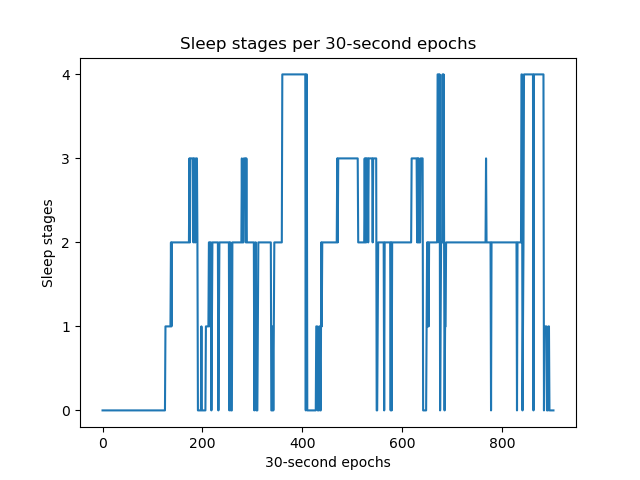

Person woke up 1 times at the middle of the night.
Person was awake for 63 minutes before falling asleep.
Person was awake for 4 minutes before ending the measurement.
+----------------------------+--------------------------------------+----------------+
| Minutes awake before sleep | Minutes awake before measurement end | Times woken up |
+----------------------------+--------------------------------------+----------------+
|             63             |                  4                   |       1        |
+----------------------------+--------------------------------------+----------------+
Deelnemer nummer: 36
+----------------------------------------------------+-------------------+
| Datum van meting                                   | 2024-08-16        |
+====================================================+===================+
| Tijd meting begonnen                               | 09:55:52          |
+----------------------------------------------------+-------------------+
|

In [108]:
# File names
results_file_name = "results.h5"
ecg_file = "MovesenseECG-2024-08-16T09_55_52.343532_sharing"
ecg_file = "C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_36/{0}.csv".format(ecg_file)

# Get all results in a table
get_results_table(ecg_file, results_file_name)

In [108]:
test = "C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_36"
import os
os.path.dirname(os.path.dirname(test))

'C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee'

In [109]:
if not os.path.exists("C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_36/preprocessed_ecg_data_participant_36/"):
    os.makedirs("C:/Users/esmee/OneDrive/Documenten/Hva jaar 4/Afstudeerstage/data/Esmee/MoveSense_data/MoveSense_participant_36/preprocessed_ecg_data_participant_36/")

# Visualisatie voor linkedin

In [109]:
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 2., 3., 3., 3., 3., 3., 3., 2., 3., 3., 2., 2.,
       3., 3., 3., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 2., 0., 1., 2.,
       2., 2., 2., 2., 2.

In [110]:
len(spike_value_df["heartrate"])

25824

In [111]:
len(predictions)

904

In [112]:
spike_value_df["Timestamp"]

40        2024-08-06 23:21:24.209916
207       2024-08-06 23:21:25.086315
357       2024-08-06 23:21:25.873500
501       2024-08-06 23:21:26.629197
639       2024-08-06 23:21:27.353407
                     ...            
5184778   2024-08-07 06:54:53.190026
5184893   2024-08-07 06:54:53.793534
5185127   2024-08-07 06:54:55.021542
5185259   2024-08-07 06:54:55.714265
5185405   2024-08-07 06:54:56.480458
Name: Timestamp, Length: 25824, dtype: datetime64[ns]

C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\308894538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\308894538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()


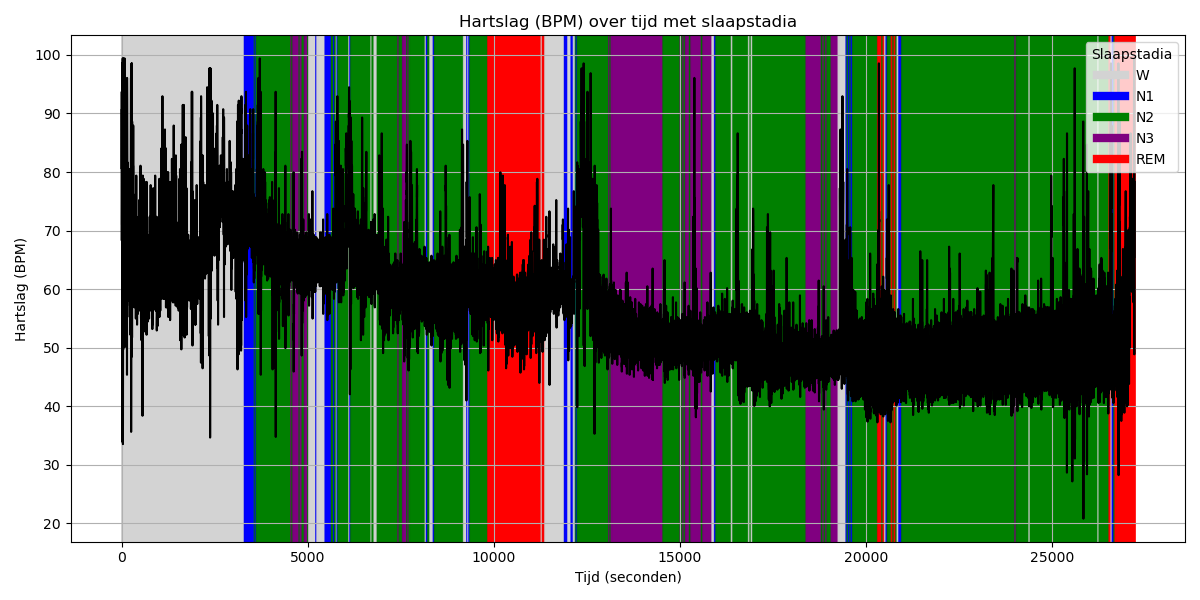

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Stap 1: timestamp converteren
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()
total_seconds = len(spike_value_df)

# Stap 2: maak een mapping van slaapstadia
stage_colors = {0: "lightgrey", 1: "blue", 2: "green", 3: "purple", 4: "red"}
stage_labels = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Stap 3: herhaal elk prediction-waarde 30 keer, en snijd het af op de lengte van spike_value_df
expanded_predictions = np.repeat(predictions, 30)[:total_seconds]

# Stap 4: Plotten
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], spike_value_df['heartrate'], color="black", label="Hartslag (BPM)")

# Achtergrond invullen op basis van slaapstadium
for i in range(total_seconds - 1):  # i+1 moet binnen bereik blijven
    stage = expanded_predictions[i]
    start = spike_value_df['Time_in_seconds'].iloc[i]
    end = spike_value_df['Time_in_seconds'].iloc[i + 1]
    plt.axvspan(start, end, color=stage_colors[stage], alpha=0.3)

# Legenda toevoegen
handles = [plt.Line2D([0], [0], color=clr, lw=6) for clr in stage_colors.values()]
labels = [stage_labels[k] for k in stage_colors.keys()]
plt.legend(handles, labels, title="Slaapstadia", loc="upper right")

# Afwerking
plt.title("Hartslag (BPM) over tijd met slaapstadia")
plt.xlabel("Tijd (seconden)")
plt.ylabel("Hartslag (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [139]:
plt.close()

C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\765184286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\765184286.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()


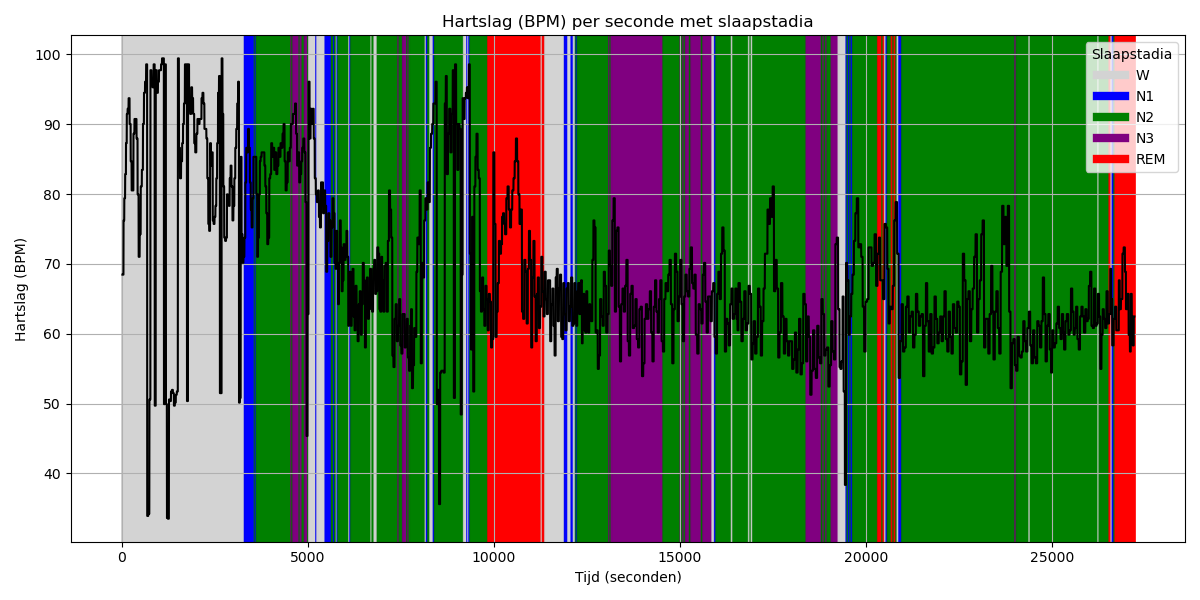

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Stap 1: timestamp converteren
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()
total_seconds = len(spike_value_df)

# Stap 2: Maak een mapping van slaapstadia
stage_colors = {0: "lightgrey", 1: "blue", 2: "green", 3: "purple", 4: "red"}
stage_labels = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Stap 3: Resample de hartslag naar per seconde, herhaal elke voorspelling 30 keer
# Veronderstel dat 'predictions' een array is van lengte 904 met de voorspellingen (0, 1, 2, 3, 4)

# Stap 3.1: Herhaal elke voorspelling 30 keer, zodat we per seconde data hebben (27120 waarden)
expanded_predictions = np.repeat(predictions, 30)[:total_seconds]

# Stap 3.2: Resample de hartslag per seconde door elke waarde 30 keer te herhalen
expanded_heart_rate = np.repeat(spike_value_df['heartrate'].values, 30)[:total_seconds]

# Stap 4: Plotten
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], expanded_heart_rate, color="black", label="Hartslag (BPM) per seconde")

# Achtergrond invullen op basis van slaapstadium
for i in range(total_seconds - 1):  # i+1 moet binnen bereik blijven
    stage = expanded_predictions[i]
    start = spike_value_df['Time_in_seconds'].iloc[i]
    end = spike_value_df['Time_in_seconds'].iloc[i + 1]
    plt.axvspan(start, end, color=stage_colors[stage], alpha=0.3)

# Legenda toevoegen
handles = [plt.Line2D([0], [0], color=clr, lw=6) for clr in stage_colors.values()]
labels = [stage_labels[k] for k in stage_colors.keys()]
plt.legend(handles, labels, title="Slaapstadia", loc="upper right")

# Afwerking
plt.title("Hartslag (BPM) per seconde met slaapstadia")
plt.xlabel("Tijd (seconden)")
plt.ylabel("Hartslag (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\esmee\AppData\Local\Temp\ipykernel_1340\2916798725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df["Time_in_seconds"] = (spike_value_df["Timestamp"] - start_time).dt.total_seconds()


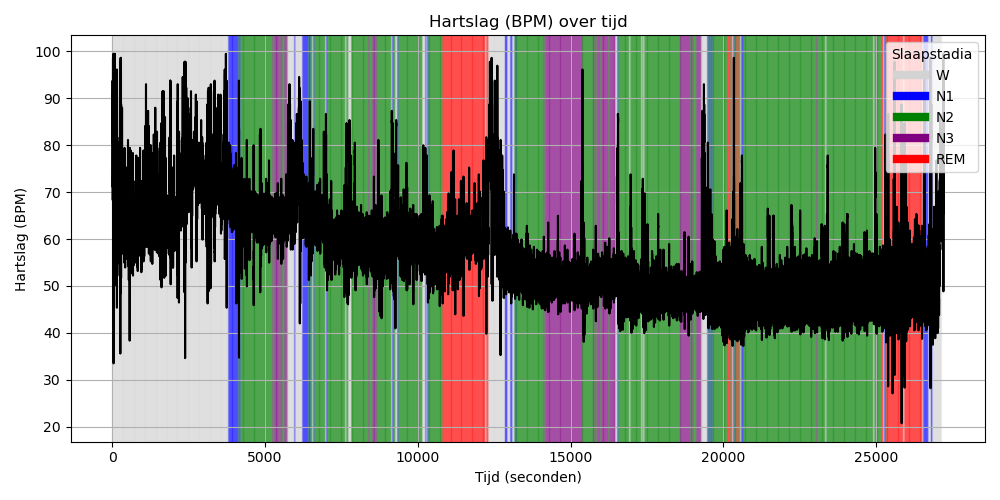

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Zet tijdstempels om naar seconden
start_time = spike_value_df["Timestamp"].min()
spike_value_df["Time_in_seconds"] = (spike_value_df["Timestamp"] - start_time).dt.total_seconds()

# Mapping van slaapstadia
stage_colors = {0: "lightgrey", 1: "blue", 2: "green", 3: "purple", 4: "red"}
stage_labels = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Plot
plt.figure(figsize=(10, 5))
plt.plot(spike_value_df["Time_in_seconds"], spike_value_df["heartrate"], color="black", label="Hartslag (BPM)")

# Voeg de slaapstadia toe als achtergrond
for i, stage in enumerate(predictions):
    start = i * 30
    end = (i + 1) * 30
    plt.axvspan(start, end, color=stage_colors[stage], alpha=0.3)

# Legenda
handles = [plt.Line2D([0], [0], color=clr, lw=6) for clr in stage_colors.values()]
labels = [stage_labels[k] for k in stage_colors.keys()]
plt.legend(handles, labels, title="Slaapstadia", loc="upper right")

plt.title("Hartslag (BPM) over tijd")
plt.xlabel("Tijd (seconden)")
plt.ylabel("Hartslag (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
spike_value_df['Timestamp']

0     2024-08-06 23:21:24.209916
1     2024-08-06 23:21:25.086315
2     2024-08-06 23:21:25.873500
3     2024-08-06 23:21:26.629197
4     2024-08-06 23:21:27.353407
                 ...            
363   2024-08-06 23:26:20.527271
364   2024-08-06 23:26:21.540116
365   2024-08-06 23:26:22.238086
366   2024-08-06 23:26:23.030519
367   2024-08-06 23:26:24.038116
Name: Timestamp, Length: 368, dtype: datetime64[ns]

In [131]:
spike_value_df['Time_in_seconds']

0        0.000000
1        0.876399
2        1.663584
3        2.419281
4        3.143491
          ...    
363    296.317355
364    297.330200
365    298.028170
366    298.820603
367    299.828200
Name: Time_in_seconds, Length: 368, dtype: float64

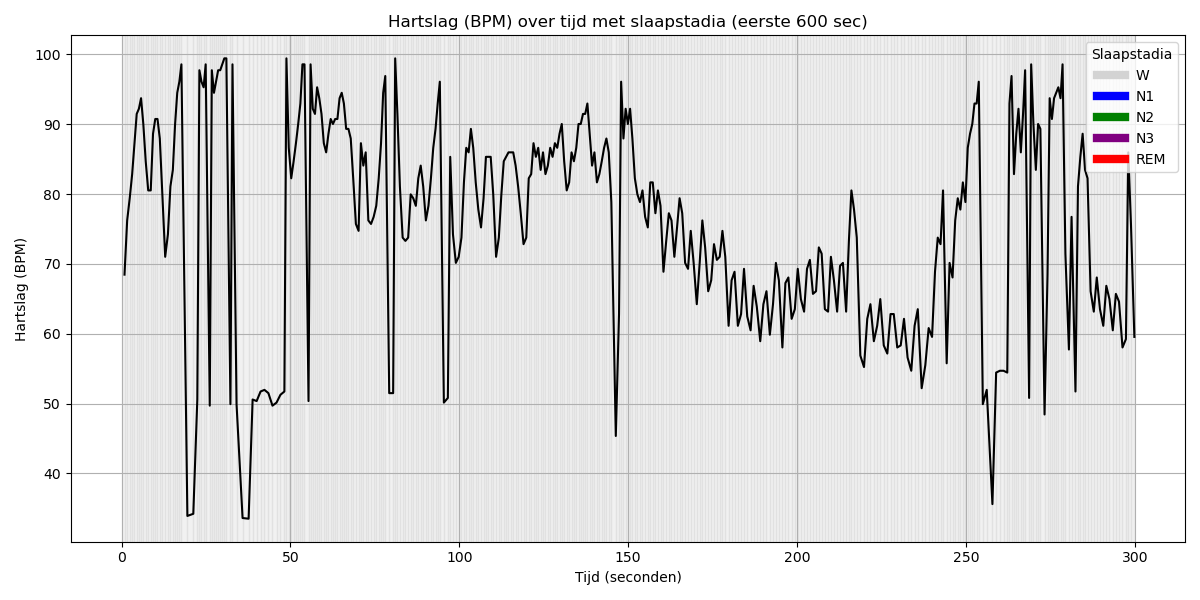

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Stap 1: timestamp converteren
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()
total_seconds = len(spike_value_df)

# Stap 2: maak een mapping van slaapstadia
stage_colors = {0: "lightgrey", 1: "blue", 2: "green", 3: "purple", 4: "red"}
stage_labels = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Stap 3: herhaal elk prediction-waarde 30 keer, en snijd het af op de lengte van spike_value_df
expanded_predictions = np.repeat(predictions, 30)[:total_seconds]

# ➕ Filter op de eerste 600 seconden
mask = spike_value_df['Time_in_seconds'] < 600
spike_value_df = spike_value_df[mask].reset_index(drop=True)
expanded_predictions = expanded_predictions[:len(spike_value_df)]
total_seconds = len(spike_value_df)

# Stap 4: Plotten
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], spike_value_df['heartrate'], color="black", label="Hartslag (BPM)")

# Achtergrond invullen op basis van slaapstadium
for i in range(total_seconds - 1):  # i+1 moet binnen bereik blijven
    stage = expanded_predictions[i]
    start = spike_value_df['Time_in_seconds'].iloc[i]
    end = spike_value_df['Time_in_seconds'].iloc[i + 1]
    plt.axvspan(start, end, color=stage_colors[stage], alpha=0.3)

# Legenda toevoegen
handles = [plt.Line2D([0], [0], color=clr, lw=6) for clr in stage_colors.values()]
labels = [stage_labels[k] for k in stage_colors.keys()]
plt.legend(handles, labels, title="Slaapstadia", loc="upper right")

# Afwerking
plt.title("Hartslag (BPM) over tijd met slaapstadia (eerste 600 sec)")
plt.xlabel("Tijd (seconden)")
plt.ylabel("Hartslag (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


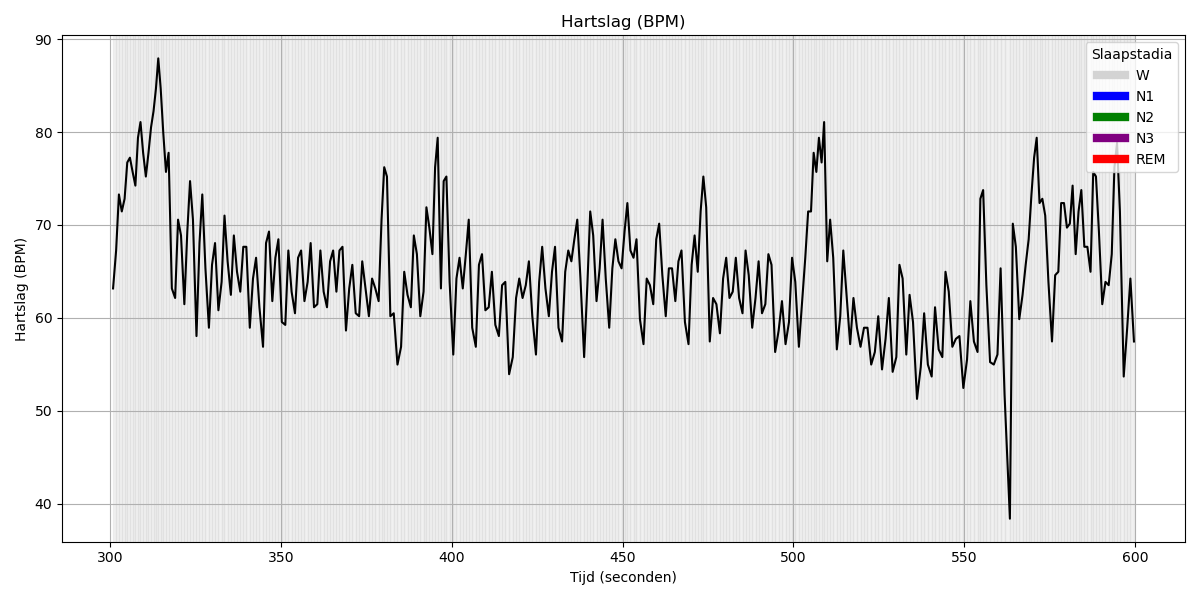

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Stap 1: timestamp converteren
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()
total_seconds = len(spike_value_df)

# Stap 2: mapping van slaapstadia
stage_colors = {0: "lightgrey", 1: "blue", 2: "green", 3: "purple", 4: "red"}
stage_labels = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Stap 3: herhaal predictions per seconde en beperk tot spike_value_df-lengte
expanded_predictions = np.repeat(predictions, 30)[:total_seconds]

# ➕ Filter op tijd tussen 300 en 900 seconden
mask = (spike_value_df['Time_in_seconds'] >= 300) & (spike_value_df['Time_in_seconds'] <= 600)
spike_value_df_filtered = spike_value_df[mask].reset_index(drop=True)
expanded_predictions_filtered = expanded_predictions[mask.values]
total_filtered = len(spike_value_df_filtered)

# Stap 4: Plotten
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df_filtered['Time_in_seconds'], spike_value_df_filtered['heartrate'], color="black", label="Hartslag (BPM)")

# Achtergrond invullen op basis van slaapstadium
for i in range(total_filtered - 1):  # i+1 moet binnen bereik blijven
    stage = expanded_predictions_filtered[i]
    start = spike_value_df_filtered['Time_in_seconds'].iloc[i]
    end = spike_value_df_filtered['Time_in_seconds'].iloc[i + 1]
    plt.axvspan(start, end, color=stage_colors[stage], alpha=0.3)

# Legenda toevoegen
handles = [plt.Line2D([0], [0], color=clr, lw=6) for clr in stage_colors.values()]
labels = [stage_labels[k] for k in stage_colors.keys()]
plt.legend(handles, labels, title="Slaapstadia", loc="upper right")

# Afwerking
plt.title("Hartslag (BPM)")
plt.xlabel("Tijd (seconden)")
plt.ylabel("Hartslag (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


Fout: De lengte van de voorspellingen (904) en het aantal seconden in de hartslagdata (25824) komen niet overeen.


C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\1065420509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\1065420509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()


KeyError: 0.0

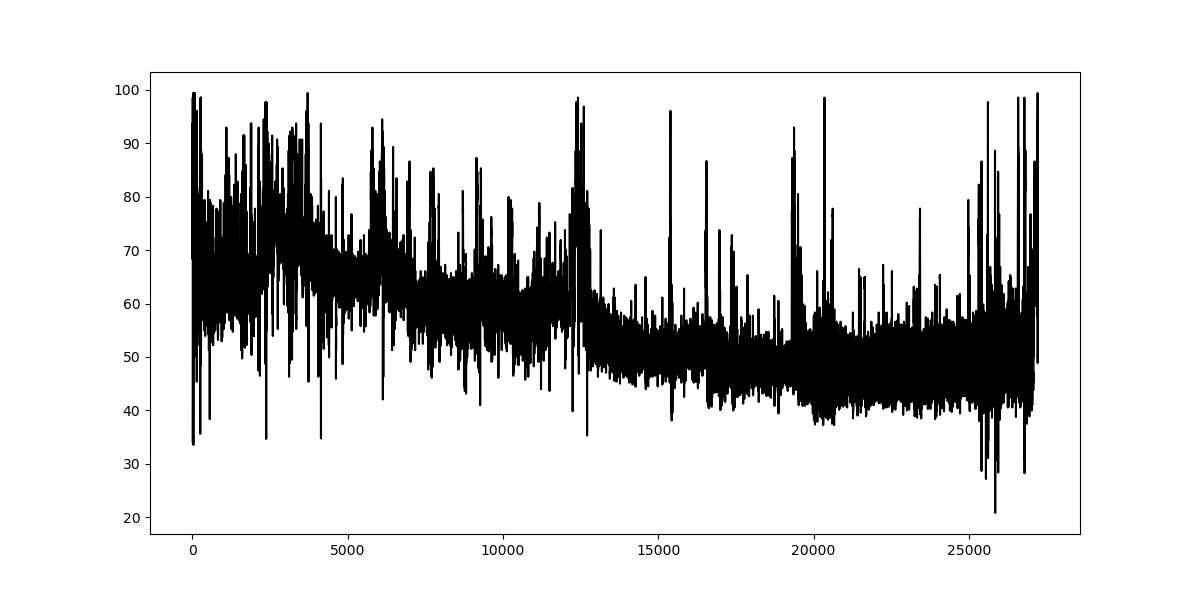

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Zorg ervoor dat je spike_value_df DataFrame correct is geladen en de juiste Timestamp kolom bevat
# Zet de Timestamp om naar datetime (indien nog niet gedaan)
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])

# Bereken de tijdsverschillen in seconden ten opzichte van het eerste tijdstip
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()

# Aantal seconden in de totale dataset (bpm per seconde)
total_seconds = len(spike_value_df)

# Controleer de lengte van de voorspellingen (moet gelijk zijn aan het aantal 30-seconden-epochs)
if len(predictions) * 30 != total_seconds:
    print(f"Fout: De lengte van de voorspellingen ({len(predictions)}) en het aantal seconden in de hartslagdata ({total_seconds}) komen niet overeen.")
else:
    print(f"Lengte van de voorspellingen komt overeen met de hartslagdata: {len(predictions)} voorspellingen voor {total_seconds} seconden.")

# Herhaal voorspellingen per 30 seconden naar 1 seconde (interpolatie)
predictions_per_second = []
for i in range(total_seconds):
    # Bereken de index van de voorspelling die hoort bij dit tijdstip
    index = i // 30  # Dit zorgt ervoor dat voorspelling elke 30 seconden wordt herhaald
    predictions_per_second.append(predictions[index])

# Zorg ervoor dat de lengtes van de voorspellingen en spike_value_df hetzelfde zijn
assert len(predictions_per_second) == total_seconds, f"Lengtes komen niet overeen: {len(predictions_per_second)} != {total_seconds}"

# Maak een kleurmap voor de slaapstadia
sleep_stages = {"W": "lightgrey", "N1": "blue", "N2": "green", "N3": "purple", "REM": "red"}

# Maak een plot van de hartslag over tijd
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], spike_value_df['heartrate'], label="Hartslag (BPM)", color="black")

# Voeg de achtergrondkleur toe op basis van de slaapstadia
for i in range(total_seconds):
    stage = predictions_per_second[i]
    start_time = spike_value_df['Time_in_seconds'].iloc[i]
    end_time = spike_value_df['Time_in_seconds'].iloc[i + 1] if i + 1 < total_seconds else spike_value_df['Time_in_seconds'].iloc[i]
    
    # Voeg de gekleurde achtergrond toe
    plt.axvspan(start_time, end_time, color=sleep_stages[stage], alpha=0.3)

# Stel de titel en labels in
plt.title("Hartslag (BPM) over tijd met slaapstadia", fontsize=14)
plt.xlabel("Tijd (seconden)", fontsize=12)
plt.ylabel("Hartslag (BPM)", fontsize=12)

# Draai de x-ticks om overlap te voorkomen
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Toon de plot
plt.show()



Fout: De lengte van de voorspellingen (904) en het aantal seconden in de hartslagdata (25824) komen niet overeen.


C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\3408451577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\3408451577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()


KeyError: 0.0

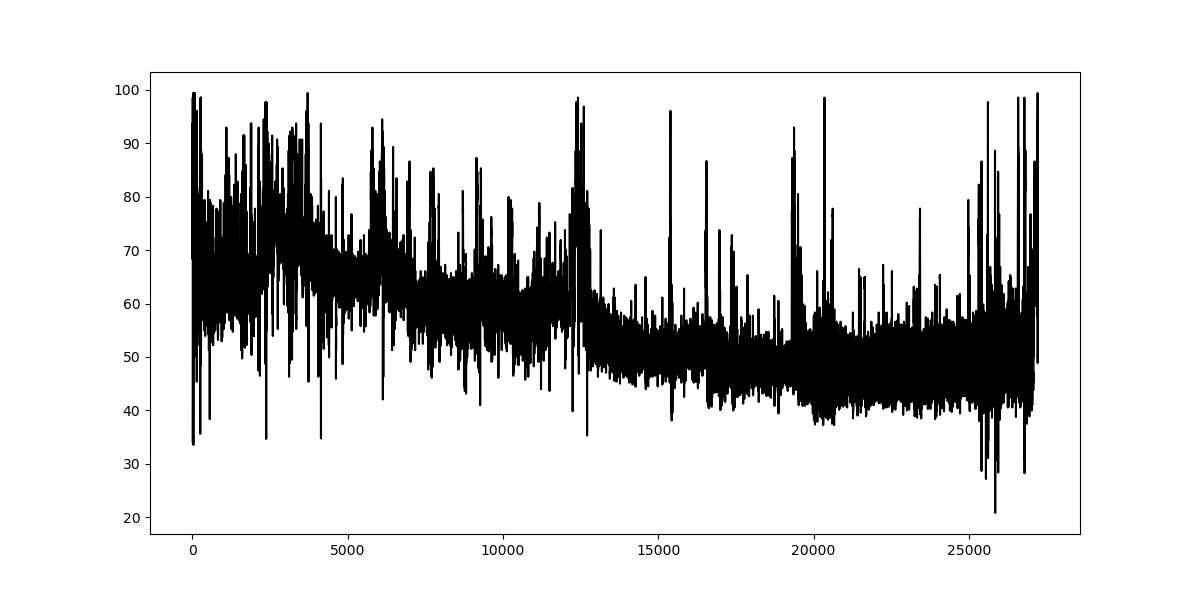

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Zorg ervoor dat je spike_value_df DataFrame correct is geladen en de juiste Timestamp kolom bevat
# Zet de Timestamp om naar datetime (indien nog niet gedaan)
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])

# Bereken de tijdsverschillen in seconden ten opzichte van het eerste tijdstip
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()

# Aantal seconden in de totale dataset (bpm per seconde)
total_seconds = len(spike_value_df)

# Controleer de lengte van de voorspellingen (moet gelijk zijn aan het aantal 30-seconden-epochs)
if len(predictions) * 30 != total_seconds:
    print(f"Fout: De lengte van de voorspellingen ({len(predictions)}) en het aantal seconden in de hartslagdata ({total_seconds}) komen niet overeen.")
else:
    print(f"Lengte van de voorspellingen komt overeen met de hartslagdata: {len(predictions)} voorspellingen voor {total_seconds} seconden.")

# Herhaal voorspellingen per 30 seconden naar 1 seconde (interpolatie)
predictions_per_second = []
for i in range(total_seconds):
    # Bereken de index van de voorspelling die hoort bij dit tijdstip
    index = i // 30  # Dit zorgt ervoor dat voorspelling elke 30 seconden wordt herhaald
    predictions_per_second.append(predictions[index])

# Zorg ervoor dat de lengtes van de voorspellingen en spike_value_df hetzelfde zijn
assert len(predictions_per_second) == total_seconds, f"Lengtes komen niet overeen: {len(predictions_per_second)} != {total_seconds}"

# Maak een kleurmap voor de slaapstadia
sleep_stages = {"W": "lightgrey", "N1": "blue", "N2": "green", "N3": "purple", "REM": "red"}

# Stel het gewenste inzoomtijdvak in (bijvoorbeeld tussen 300 seconden en 600 seconden)
start_time_zoom = 300  # Starttijd voor inzoomen (in seconden)
end_time_zoom = 600    # Eindtijd voor inzoomen (in seconden)

# Maak een plot van de hartslag over tijd
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], spike_value_df['heartrate'], label="Hartslag (BPM)", color="black")

# Voeg de achtergrondkleur toe op basis van de slaapstadia binnen het gekozen tijdsinterval
for i in range(total_seconds):
    stage = predictions_per_second[i]
    start_time = spike_value_df['Time_in_seconds'].iloc[i]
    end_time = spike_value_df['Time_in_seconds'].iloc[i + 1] if i + 1 < total_seconds else spike_value_df['Time_in_seconds'].iloc[i]

    # Controleer of de tijd binnen het zoominterval valt
    if start_time >= start_time_zoom and end_time <= end_time_zoom:
        # Voeg de gekleurde achtergrond toe
        plt.axvspan(start_time, end_time, color=sleep_stages[stage], alpha=0.3)

# Stel de grenzen van de x-as in om in te zoomen op het gewenste tijdsinterval
plt.xlim(start_time_zoom, end_time_zoom)

# Stel de titel en labels in
plt.title("Hartslag (BPM) over tijd", fontsize=14)
plt.xlabel("Tijd (seconden)", fontsize=12)
plt.ylabel("Hartslag (BPM)", fontsize=12)

# Draai de x-ticks om overlap te voorkomen
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Toon de plot
plt.show()

In [150]:
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 2., 3., 3., 3., 3., 3., 3., 2., 3., 3., 2., 2.,
       3., 3., 3., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 2., 0., 1., 2.,
       2., 2., 2., 2., 2.

In [151]:
# Herhaal elke voorspelling 30 keer
expanded_predictions = np.tile(predictions, 30)

# Nu is expanded_predictions een lijst waarbij elke voorspelling 30 keer herhaald is
print(expanded_predictions)

[0. 0. 0. ... 0. 0. 0.]


In [153]:
desired_values = expanded_predictions[:25842]

In [154]:
len(desired_values)

25842

Fout: De lengte van de voorspellingen (904) en het aantal seconden in de hartslagdata (25824) komen niet overeen.


C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\1713660999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])
C:\Users\esmee\AppData\Local\Temp\ipykernel_4392\1713660999.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()


KeyError: 0.0

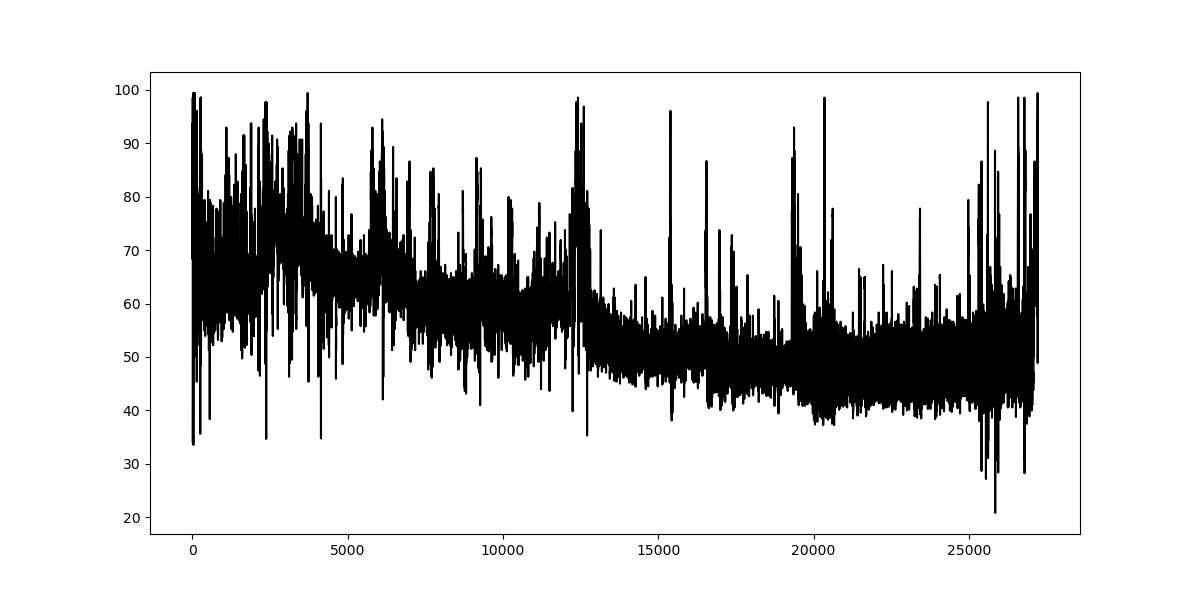

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Zorg ervoor dat je spike_value_df DataFrame correct is geladen en de juiste Timestamp kolom bevat
# Zet de Timestamp om naar datetime (indien nog niet gedaan)
spike_value_df['Timestamp'] = pd.to_datetime(spike_value_df['Timestamp'])

# Bereken de tijdsverschillen in seconden ten opzichte van het eerste tijdstip
spike_value_df['Time_in_seconds'] = (spike_value_df['Timestamp'] - spike_value_df['Timestamp'].iloc[0]).dt.total_seconds()

# Aantal seconden in de totale dataset (bpm per seconde)
total_seconds = len(spike_value_df)

# Controleer de lengte van de voorspellingen (moet gelijk zijn aan het aantal 30-seconden-epochs)
if len(predictions) * 30 != total_seconds:
    print(f"Fout: De lengte van de voorspellingen ({len(predictions)}) en het aantal seconden in de hartslagdata ({total_seconds}) komen niet overeen.")
else:
    print(f"Lengte van de voorspellingen komt overeen met de hartslagdata: {len(predictions)} voorspellingen voor {total_seconds} seconden.")

# Herhaal voorspellingen per 30 seconden naar 1 seconde (interpolatie)
predictions_per_second = []
for i in range(total_seconds):
    # Bereken de index van de voorspelling die hoort bij dit tijdstip
    index = i // 30  # Dit zorgt ervoor dat voorspelling elke 30 seconden wordt herhaald
    predictions_per_second.append(predictions[index])

# Zorg ervoor dat de lengtes van de voorspellingen en spike_value_df hetzelfde zijn
assert len(predictions_per_second) == total_seconds, f"Lengtes komen niet overeen: {len(predictions_per_second)} != {total_seconds}"

# Maak een kleurmap voor de slaapstadia
sleep_stages = {"W": "lightgrey", "N1": "blue", "N2": "green", "N3": "purple", "REM": "red"}

# Stel het gewenste inzoomtijdvak in (bijvoorbeeld tussen 300 seconden en 600 seconden)
start_time_zoom = 300  # Starttijd voor inzoomen (in seconden)
end_time_zoom = 600    # Eindtijd voor inzoomen (in seconden)

# Maak een plot van de hartslag over tijd
plt.figure(figsize=(12, 6))
plt.plot(spike_value_df['Time_in_seconds'], spike_value_df['heartrate'], label="Hartslag (BPM)", color="black")

# Voeg de achtergrondkleur toe op basis van de slaapstadia binnen het gekozen tijdsinterval
for i in range(1, total_seconds):
    stage = predictions_per_second[i]
    start_time = spike_value_df['Time_in_seconds'].iloc[i-1]  # Begin van de tijd
    end_time = spike_value_df['Time_in_seconds'].iloc[i]  # Eindtijd van de tijd

    # Controleer of de tijd binnen het zoominterval valt
    if start_time >= start_time_zoom and end_time <= end_time_zoom:
        # Voeg de gekleurde achtergrond toe (voor elke 30 seconden een kleur)
        plt.axvspan(start_time, end_time, color=sleep_stages[stage], alpha=0.3)

# Stel de grenzen van de x-as in om in te zoomen op het gewenste tijdsinterval
plt.xlim(start_time_zoom, end_time_zoom)

# Stel de titel en labels in
plt.title("Hartslag (BPM) over tijd met slaapstadia", fontsize=14)
plt.xlabel("Tijd (seconden)", fontsize=12)
plt.ylabel("Hartslag (BPM)", fontsize=12)

# Draai de x-ticks om overlap te voorkomen
plt.xticks(rotation=45)
plt.grid(True)

# Voeg de legenda toe voor de slaapstadia in de rechterbovenhoek
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in sleep_stages.values()]
labels = list(sleep_stages.keys())
plt.legend(handles=handles, labels=labels, title="Slaapstadia", loc='upper right')

plt.tight_layout()

# Toon de plot
plt.show()


In [133]:
predictions

['W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
 'N3',
 'REM',
 'W',
 'N1',
 'N2',
